In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [ ]:
# Load final dataset
df_final = pd.read_csv('final_economic_shocks_dataset.csv')
df_final['Month'] = pd.to_datetime(df_final['Month'])
df_final['Quarter'] = df_final['Month'].dt.to_period('Q').dt.start_time
df_final['GDP'] = pd.to_numeric(df_final['GDP'], errors='coerce')

# Load historical GDP dataset
df_hist = pd.read_csv('LORSGPORIEQ661S.csv')
df_hist['observation_date'] = pd.to_datetime(df_hist['observation_date'])
df_hist['LORSGPORIEQ661S'] = pd.to_numeric(df_hist['LORSGPORIEQ661S'], errors='coerce')
df_hist['Quarter'] = df_hist['observation_date'].dt.to_period('Q').dt.start_time

In [ ]:
# Find overlapping data with non-null GDP in final dataset
df_overlap = df_final.merge(df_hist[['Quarter', 'LORSGPORIEQ661S', 'observation_date']], on='Quarter', how='inner')
df_overlap = df_overlap[df_overlap['GDP'].notnull()]
df_overlap['GDP_Difference'] = df_overlap['GDP'] - df_overlap['LORSGPORIEQ661S']

# Print overlap summary
print("\nOverlap Summary:")
print(f"Total rows in final dataset: {len(df_final)}")
print(f"Total rows in historical dataset: {len(df_hist)}")
print(f"Overlapping rows with non-null GDP: {len(df_overlap)}")
print(f"Date range in final dataset: {df_final['Month'].min()} to {df_final['Month'].max()}")
print(f"Date range in historical dataset: {df_hist['observation_date'].min()} to {df_hist['observation_date'].max()}")
print(f"Overlap date range: {df_overlap['Month'].min()} to {df_overlap['Month'].max()}")
print("\nSample of Overlapping Values (first 5):")
print(df_overlap[['Month', 'GDP', 'LORSGPORIEQ661S', 'GDP_Difference']].head())
print("\nSummary of GDP Differences:")
print(df_overlap['GDP_Difference'].describe())



Overlap Summary:
Total rows in final dataset: 594
Total rows in historical dataset: 251
Overlapping rows with non-null GDP: 333
Date range in final dataset: 1975-11-01 00:00:00 to 2025-04-01 00:00:00
Date range in historical dataset: 1960-01-01 00:00:00 to 2022-07-01 00:00:00
Overlap date range: 1995-01-01 00:00:00 to 2022-09-01 00:00:00

Sample of Overlapping Values (first 5):
         Month      GDP  LORSGPORIEQ661S  GDP_Difference
230 1995-01-01  19516.8         34.85028     19481.94972
231 1995-02-01  19516.8         34.85028     19481.94972
232 1995-03-01  19516.8         34.85028     19481.94972
233 1995-04-01  20305.4         35.58039     20269.81961
234 1995-05-01  20305.4         35.58039     20269.81961

Summary of GDP Differences:
count       333.000000
mean      46931.997063
std       19782.137283
min       19481.949720
25%       34239.893023
50%       42279.160172
75%       58121.896630
max      106478.649436
Name: GDP_Difference, dtype: float64


In [ ]:
df_final.to_csv('final_economic_shocks_imputed.csv', index=False)
print("Imputation completed. Saved to 'final_economic_shocks_imputed.csv'.")

Imputation completed. Saved to 'final_economic_shocks_imputed.csv'.


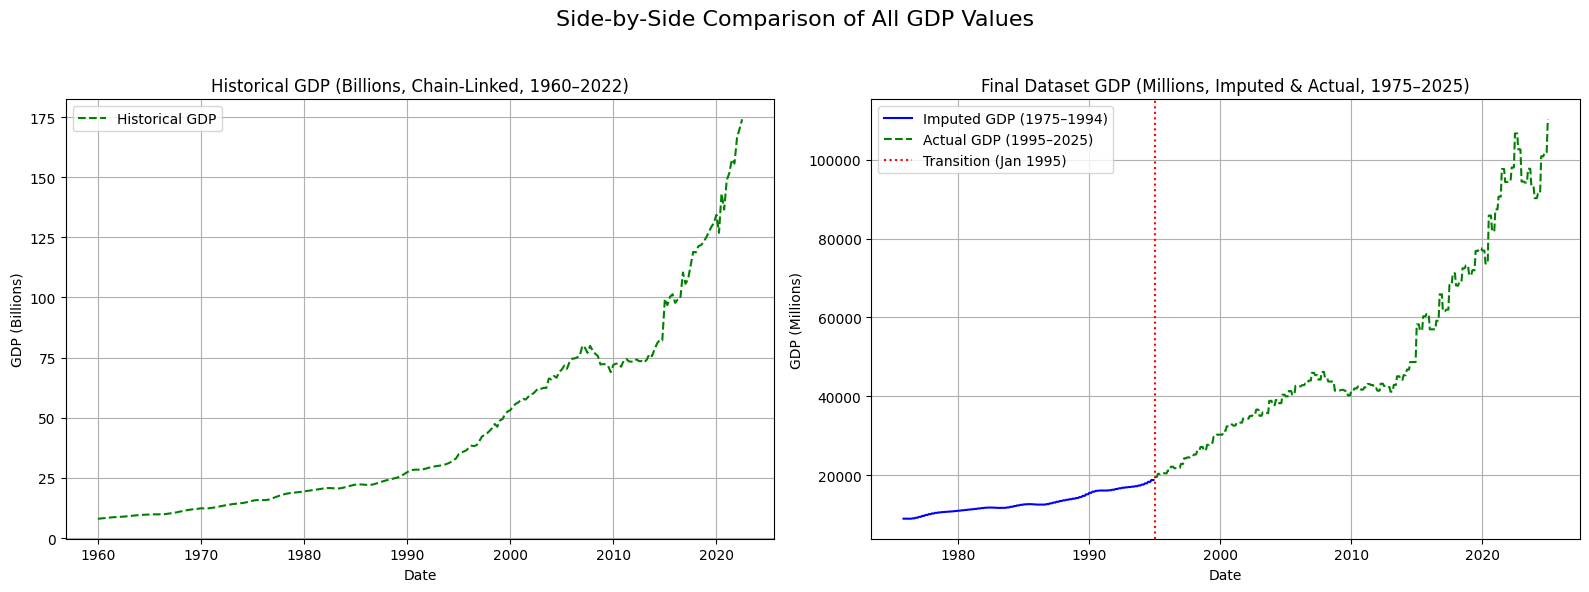

In [ ]:
# Create side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharex=False)

# Left subplot: All Historical GDP
ax1.plot(df_hist['observation_date'], df_hist['LORSGPORIEQ661S'], label='Historical GDP', color='green', linestyle='--')
ax1.set_title('Historical GDP (Billions, Chain-Linked, 1960–2022)')
ax1.set_xlabel('Date')
ax1.set_ylabel('GDP (Billions)')
ax1.legend()
ax1.grid(True)

# Right subplot: All Final Dataset GDP (imputed + actual)
ax2.plot(df_imputed['Month'], df_imputed['GDP'], label='Imputed GDP (1975–1994)', color='blue', linestyle='-')
ax2.plot(df_actual['Month'], df_actual['GDP'], label='Actual GDP (1995–2025)', color='green', linestyle='--')
ax2.axvline(pd.to_datetime('1995-01-01'), color='red', linestyle=':', label='Transition (Jan 1995)')
ax2.set_title('Final Dataset GDP (Millions, Imputed & Actual, 1975–2025)')
ax2.set_xlabel('Date')
ax2.set_ylabel('GDP (Millions)')
ax2.legend()
ax2.grid(True)

# Adjust layout and display
plt.suptitle('Side-by-Side Comparison of All GDP Values', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
# Load datasets
unemployment_df = pd.read_csv('Unemployment_rate - Sheet1.csv')
economic_df = pd.read_csv('final_economic_shocks_imputed.csv')

# Prepare unemployment data
unemployment_df['DATE'] = pd.to_datetime(unemployment_df['DATE'])
unemployment_df.rename(columns={'VALUE': 'Unemployed'}, inplace=True)

# Prepare economic data
economic_df['Month'] = pd.to_datetime(economic_df['Month'])
economic_df['Quarter'] = economic_df['Month'].dt.to_period('Q').dt.to_timestamp()
# Aggregate Population to quarterly by averaging
quarterly_pop = economic_df.groupby('Quarter')['Population'].mean().reset_index()

In [ ]:
from sklearn.linear_model import LinearRegression

# Extrapolate Population for 1967–1975
pop_train = quarterly_pop[(quarterly_pop['Quarter'] >= '1975-10-01') & (quarterly_pop['Quarter'] <= '1985-12-31')]
years = pop_train['Quarter'].dt.year.values.reshape(-1, 1)
pop_values = pop_train['Population'].values
pop_model = LinearRegression()
pop_model.fit(years, pop_values)

# Generate quarterly dates for 1967–1975
early_dates = pd.date_range(start='1967-01-01', end='1975-07-01', freq='QS')
early_pop = pd.DataFrame({'Quarter': early_dates})
early_pop['Year'] = early_pop['Quarter'].dt.year
early_pop['Population'] = pop_model.predict(early_pop['Year'].values.reshape(-1, 1))
early_pop.drop(columns=['Year'], inplace=True)

# Combine extrapolated and actual Population
quarterly_pop = pd.concat([early_pop, quarterly_pop], ignore_index=True)
quarterly_pop['Quarter'] = pd.to_datetime(quarterly_pop['Quarter'])

# Merge datasets
merged_df = pd.merge(unemployment_df, quarterly_pop, left_on='DATE', right_on='Quarter', how='left')
merged_df.drop(columns=['Quarter'], inplace=True)

In [ ]:
# Calculate UnemploymentRate
merged_df['UnemploymentRate'] = (merged_df['Unemployed'] / merged_df['Population']) * 100

# Handle any missing values
print(f"\nRows with missing Population: {merged_df['Population'].isnull().sum()}")
print(f"Rows with missing UnemploymentRate: {merged_df['UnemploymentRate'].isnull().sum()}")

# Save output
merged_df.to_csv('unemployment_rate_calculated.csv', index=False)
print("\nSaved dataset with UnemploymentRate to 'unemployment_rate_calculated.csv'.")


Rows with missing Population: 0
Rows with missing UnemploymentRate: 0

Saved dataset with UnemploymentRate to 'unemployment_rate_calculated.csv'.


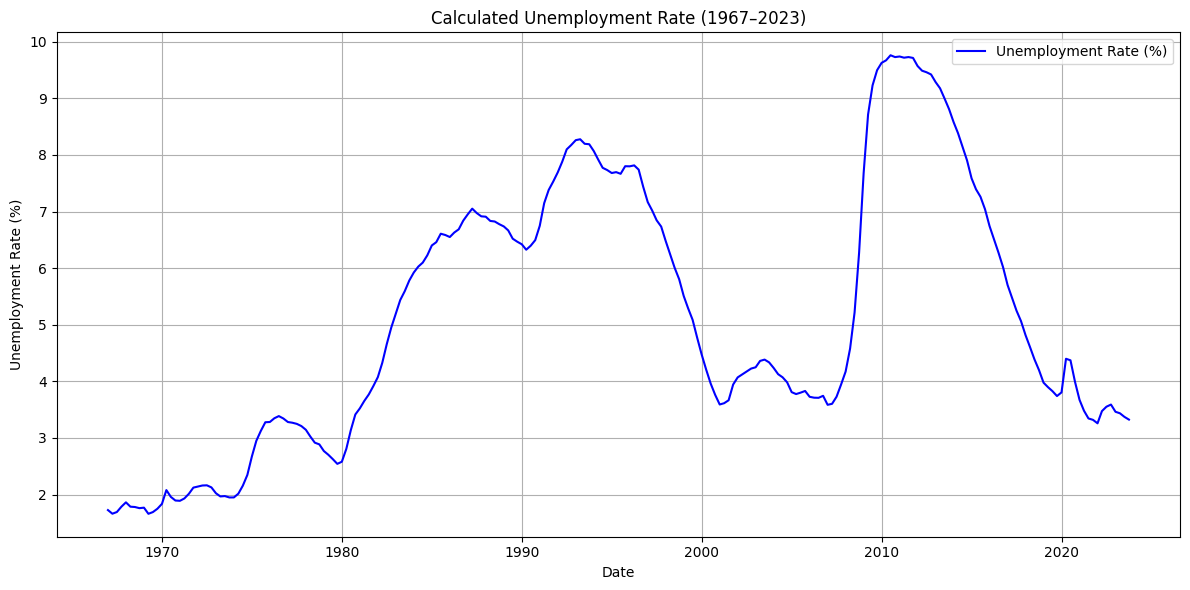

In [ ]:
# Plot UnemploymentRate
plt.figure(figsize=(12, 6))
plt.plot(merged_df['DATE'], merged_df['UnemploymentRate'], label='Unemployment Rate (%)', color='blue')
plt.title('Calculated Unemployment Rate (1967–2023)')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate (%)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Loading datasets
unemployment_df = pd.read_csv('unemployment_rate_calculated.csv')
economic_df = pd.read_csv('final_economic_shocks_imputed.csv')

# Preparing unemployment data
unemployment_df['DATE'] = pd.to_datetime(unemployment_df['DATE'])
unemployment_df = unemployment_df[unemployment_df['DATE'].between('1975-10-01', '1998-12-01')]

# Preparing economic data
economic_df['Month'] = pd.to_datetime(economic_df['Month'])
economic_df['UnemploymentRate'] = pd.to_numeric(economic_df['UnemploymentRate'], errors='coerce')

In [ ]:
# Interpolating quarterly UnemploymentRate to monthly
monthly_dates = pd.date_range(start='1975-11-01', end='1998-12-01', freq='MS')
monthly_ur = pd.DataFrame({'Month': monthly_dates})
monthly_ur['Quarter'] = monthly_ur['Month'].dt.to_period('Q').dt.to_timestamp()
monthly_ur = pd.merge(monthly_ur, unemployment_df[['DATE', 'UnemploymentRate']], left_on='Quarter', right_on='DATE', how='left')
monthly_ur.drop(columns=['Quarter', 'DATE'], inplace=True)
monthly_ur.set_index('Month', inplace=True)
monthly_ur['UnemploymentRate'] = monthly_ur['UnemploymentRate'].interpolate(method='linear')
monthly_ur.reset_index(inplace=True)

# Imputing UnemploymentRate in economic dataset
mask = (economic_df['Month'].between('1975-11-01', '1998-12-01')) & (economic_df['UnemploymentRate'].isnull())
economic_df = pd.merge(economic_df, monthly_ur[['Month', 'UnemploymentRate']], on='Month', how='left', suffixes=('', '_imputed'))
economic_df.loc[mask, 'UnemploymentRate'] = economic_df.loc[mask, 'UnemploymentRate_imputed']
economic_df.drop(columns=['UnemploymentRate_imputed'], inplace=True)

# Printing summary
print(f"\nTotal rows: {len(economic_df)}")
print(f"Missing UnemploymentRate before imputation: {economic_df['UnemploymentRate'].isnull().sum() + mask.sum()}")
print(f"Imputed rows for 1975–1998: {mask.sum()}")
print("\nSample around 1975–1976:")
print(economic_df[economic_df['Month'].isin(['1975-11-01', '1975-12-01', '1976-01-01'])][['Month', 'UnemploymentRate', 'LiveRegister']])
print("\nSample around 1998–1999:")
print(economic_df[economic_df['Month'].isin(['1998-12-01', '1999-01-01', '1999-02-01'])][['Month', 'UnemploymentRate', 'LiveRegister']])



Total rows: 594
Missing UnemploymentRate before imputation: 485
Imputed rows for 1975–1998: 274

Sample around 1975–1976:
       Month  UnemploymentRate  LiveRegister
0 1975-11-01          3.277518      102370.0
1 1975-12-01          3.277518      109311.0
2 1976-01-01          3.281904      110467.0

Sample around 1998–1999:
         Month  UnemploymentRate  LiveRegister
277 1998-12-01          5.804145      215752.0
278 1999-01-01          6.300000      214014.0
279 1999-02-01               NaN      207611.0


/tmp/ipython-input-24-1051017188.py:22: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  print(economic_df[economic_df['Month'].isin(['1975-11-01', '1975-12-01', '1976-01-01'])][['Month', 'UnemploymentRate', 'LiveRegister']])
/tmp/ipython-input-24-1051017188.py:24: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  print(economic_df[economic_df['Month'].isin(['1998-12-01', '1999-01-01', '1999-02-01'])][['Month', 'UnemploymentRate', 'LiveRegister']])


In [ ]:
import pandas as pd
import numpy as np

# Load datasets
unemployment_df = pd.read_csv('unemployment_rate_calculated.csv')
economic_df = pd.read_csv('final_economic_shocks_dataset.csv')

# Prepare unemployment data
unemployment_df['DATE'] = pd.to_datetime(unemployment_df['DATE'])
unemployment_df = unemployment_df[unemployment_df['DATE'].between('1975-10-01', '1998-12-01')]
unemployment_df['UnemploymentRate'] = pd.to_numeric(unemployment_df['UnemploymentRate'], errors='coerce')

# Prepare economic data
economic_df['Month'] = pd.to_datetime(economic_df['Month'])
economic_df['UnemploymentRate'] = pd.to_numeric(economic_df['UnemploymentRate'], errors='coerce')

# Interpolate quarterly UnemploymentRate to monthly for the entire period
monthly_dates = pd.date_range(start='1975-11-01', end='2025-04-01', freq='MS')
monthly_ur = pd.DataFrame({'Month': monthly_dates})
monthly_ur['Quarter'] = monthly_ur['Month'].dt.to_period('Q').dt.to_timestamp()

# Merge with unemployment data
monthly_ur = pd.merge(monthly_ur, unemployment_df[['DATE', 'UnemploymentRate']],
                     left_on='Quarter', right_on='DATE', how='left')
monthly_ur.drop(columns=['Quarter', 'DATE'], inplace=True)
monthly_ur.set_index('Month', inplace=True)

# Interpolate missing UnemploymentRate values
monthly_ur['UnemploymentRate'] = monthly_ur['UnemploymentRate'].interpolate(method='linear')

# Extrapolate for any remaining NaN values at the boundaries
monthly_ur['UnemploymentRate'] = monthly_ur['UnemploymentRate'].ffill().bfill()
monthly_ur.reset_index(inplace=True)

# Impute UnemploymentRate in economic dataset
mask = economic_df['UnemploymentRate'].isnull()
economic_df = pd.merge(economic_df, monthly_ur[['Month', 'UnemploymentRate']],
                      on='Month', how='left', suffixes=('', '_imputed'))
economic_df.loc[mask, 'UnemploymentRate'] = economic_df.loc[mask, 'UnemploymentRate_imputed']
economic_df.drop(columns=['UnemploymentRate_imputed'], inplace=True)

# Ensure no remaining missing UnemploymentRate values by interpolating within economic_df
economic_df.set_index('Month', inplace=True)
economic_df['UnemploymentRate'] = economic_df['UnemploymentRate'].interpolate(method='linear')
economic_df['UnemploymentRate'] = economic_df['UnemploymentRate'].ffill().bfill()
economic_df.reset_index(inplace=True)

# Save the fully imputed dataset
output_file = 'final_economic_shocks_fully_imputed.csv'
economic_df.to_csv(output_file, index=False)

# Print summary
print(f"\nTotal rows: {len(economic_df)}")
print(f"Missing UnemploymentRate after imputation: {economic_df['UnemploymentRate'].isnull().sum()}")
print(f"Imputed rows: {mask.sum()}")
print("\nSample around 1975–1976:")
print(economic_df[economic_df['Month'].isin(['1975-11-01', '1975-12-01', '1976-01-01'])][['Month', 'UnemploymentRate', 'LiveRegister']])
print("\nSample around 1998–1999:")
print(economic_df[economic_df['Month'].isin(['1998-12-01', '1999-01-01', '1999-02-01'])][['Month', 'UnemploymentRate', 'LiveRegister']])

print(f"\nImputation completed. Saved to '{output_file}'.")


Total rows: 594
Missing UnemploymentRate after imputation: 0
Imputed rows: 485

Sample around 1975–1976:
       Month  UnemploymentRate  LiveRegister
0 1975-11-01          3.277518      102370.0
1 1975-12-01          3.277518      109311.0
2 1976-01-01          3.281904      110467.0

Sample around 1998–1999:
         Month  UnemploymentRate  LiveRegister
277 1998-12-01          5.804145      215752.0
278 1999-01-01          6.300000      214014.0
279 1999-02-01          5.804145      207611.0

Imputation completed. Saved to 'final_economic_shocks_fully_imputed.csv'.


/tmp/ipython-input-29-1107204258.py:57: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  print(economic_df[economic_df['Month'].isin(['1975-11-01', '1975-12-01', '1976-01-01'])][['Month', 'UnemploymentRate', 'LiveRegister']])
/tmp/ipython-input-29-1107204258.py:59: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  print(economic_df[economic_df['Month'].isin(['1998-12-01', '1999-01-01', '1999-02-01'])][['Month', 'UnemploymentRate', 'LiveRegister']])


In [ ]:
# Load the dataset
df = pd.read_csv("final_economic_shocks_fully_imputed.csv")

# Convert 'Month' to datetime
df['Month'] = pd.to_datetime(df['Month'])

# Ensure numeric columns are properly typed
numeric_cols = ['LiveRegister', 'JobseekRate_per100k', 'UnemploymentRate', 'CPI', 'GDP',
                'Population', 'PUP_Count', 'WSS_Recipients']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Add Year column for yearly aggregation
df['Year'] = df['Month'].dt.year

In [ ]:
#Check for missing values
print("Missing Values Summary:")
missing_values = df.isnull().sum()
missing_percent = (df.isnull().sum() / len(df) * 100).round(2)
missing_summary = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing Percentage (%)': missing_percent
})
print(missing_summary)


Missing Values Summary:
                     Missing Count  Missing Percentage (%)
Month                            0                    0.00
LiveRegister                     0                    0.00
JobseekRate_per100k             15                    2.53
UnemploymentRate                 0                    0.00
CPI                              0                    0.00
GDP                            233                   39.23
Population                      15                    2.53
PUP_Count                      569                   95.79
WSS_Recipients                   0                    0.00
Year                             0                    0.00


In [ ]:
import pandas as pd

# Load datasets
primary_df = pd.read_csv("final_economic_shocks_imputed.csv")
secondary_df = pd.read_csv("Unemployment_rate - Sheet1.csv")

# Convert date columns to datetime
primary_df['Month'] = pd.to_datetime(primary_df['Month'])
secondary_df['DATE'] = pd.to_datetime(secondary_df['DATE'])

# Ensure numeric columns in primary dataset
numeric_cols = ['LiveRegister', 'JobseekRate_per100k', 'UnemploymentRate', 'CPI', 'GDP',
                'Population', 'PUP_Count', 'WSS_Recipients']
for col in numeric_cols:
    primary_df[col] = pd.to_numeric(primary_df[col], errors='coerce')

In [ ]:
# Print missing UnemploymentRate values before merge
print("Missing UnemploymentRate values in primary dataset before merge:",
      primary_df['UnemploymentRate'].isnull().sum())

Missing UnemploymentRate values in primary dataset before merge: 485


In [ ]:
# Create a monthly index for interpolation from secondary dataset
secondary_df = secondary_df.set_index('DATE')
monthly_index = pd.date_range(start=secondary_df.index.min(),
                             end=secondary_df.index.max() + pd.offsets.MonthEnd(2),
                             freq='MS')
monthly_df = pd.DataFrame(index=monthly_index)

# Interpolate VALUE to monthly frequency
monthly_df['VALUE'] = secondary_df['VALUE'].reindex(monthly_index).interpolate(method='linear')
monthly_df = monthly_df.reset_index().rename(columns={'index': 'Month'})

# Merge datasets on Month
merged_df = primary_df.merge(monthly_df, on='Month', how='left')

# Convert VALUE (persons) to percentage using Population where available
merged_df['UnemploymentRate_new'] = merged_df.apply(
    lambda row: (row['VALUE'] / row['Population'] * 100) if pd.notnull(row['VALUE']) and pd.notnull(row['Population'])
    else row['UnemploymentRate'], axis=1)

# Replace UnemploymentRate with new values where available, otherwise keep original
merged_df['UnemploymentRate'] = merged_df['UnemploymentRate_new'].combine_first(merged_df['UnemploymentRate'])

# Drop temporary columns
merged_df = merged_df.drop(columns=['VALUE', 'UnemploymentRate_new'])

# Impute remaining missing UnemploymentRate values
print("Missing UnemploymentRate values after merge:",
      merged_df['UnemploymentRate'].isnull().sum())
merged_df = merged_df.sort_values('Month')
merged_df['UnemploymentRate'] = merged_df['UnemploymentRate'].interpolate(method='linear')
print("Missing UnemploymentRate values after final imputation:",
      merged_df['UnemploymentRate'].isnull().sum())

Missing UnemploymentRate values after merge: 12
Missing UnemploymentRate values after final imputation: 0


In [ ]:
# Save the merged dataset
output_file = "merged_economic_shocks.csv"
merged_df.to_csv(output_file, index=False)
print(f"Merged dataset saved as '{output_file}'")

Merged dataset saved as 'merged_economic_shocks.csv'


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from statsmodels.tsa.seasonal import seasonal_decompose
import os
from datetime import datetime

In [ ]:
# Loading data
df = pd.read_csv('merged_economic_shocks.csv', parse_dates=['Month', 'Quarter'])

# Converting numerical columns to float, handling missing values
numeric_cols = ['LiveRegister', 'JobseekRate_per100k', 'UnemploymentRate', 'CPI', 'GDP',
                'Population', 'PUP_Count', 'WSS_Recipients']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Missing Values Analysis
print("Missing Values Count:")
print(df.isna().sum())


Missing Values Count:
Month                    0
LiveRegister             0
JobseekRate_per100k     15
UnemploymentRate         0
CPI                      0
GDP                      3
Population              15
PUP_Count              569
WSS_Recipients           0
Quarter                  0
dtype: int64


In [ ]:
# Create 'plots' directory if it doesn't exist
if not os.path.exists('plots'):
    os.makedirs('plots')

# Univariate Analysis
def univariate_analysis(df, cols):
    print("\nUnivariate Analysis - Summary Statistics:")
    for col in cols:
        print(f"\n{col}:")
        print(df[col].describe())

        # Histogram
        plt.figure()
        sns.histplot(df[col].dropna(), kde=True)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.savefig(f'plots/hist_{col}.png')
        plt.close()

        # Boxplot
        plt.figure()
        sns.boxplot(y=df[col].dropna())
        plt.title(f'Boxplot of {col}')
        plt.ylabel(col)
        plt.savefig(f'plots/box_{col}.png')
        plt.close()

univariate_analysis(df, numeric_cols)

# Bivariate Analysis
def bivariate_analysis(df):
    # UnemploymentRate vs. CPI
    plt.figure()
    sns.scatterplot(data=df, x='UnemploymentRate', y='CPI', hue=df['Month'].dt.year, size=df['Month'].dt.year)
    plt.title('Unemployment Rate vs. CPI')
    plt.xlabel('Unemployment Rate (%)')
    plt.ylabel('CPI (Index)')
    valid_data = df[['UnemploymentRate', 'CPI']].dropna()
    if len(valid_data) > 1:
        corr, p_value = pearsonr(valid_data['UnemploymentRate'], valid_data['CPI'])
        plt.text(0.05, 0.95, f'Pearson r: {corr:.2f}, p-value: {p_value:.4f}', transform=plt.gca().transAxes)
    plt.savefig('plots/scatter_unemployment_cpi.png')
    plt.close()

    # LiveRegister vs. JobseekRate_per100k
    plt.figure()
    sns.scatterplot(data=df, x='LiveRegister', y='JobseekRate_per100k', hue=df['Month'].dt.year)
    plt.title('LiveRegister vs. JobseekRate_per100k')
    plt.xlabel('LiveRegister (Persons)')
    plt.ylabel('JobseekRate_per100k')
    valid_data = df[['LiveRegister', 'JobseekRate_per100k']].dropna()
    if len(valid_data) > 1:
        corr, p_value = pearsonr(valid_data['LiveRegister'], valid_data['JobseekRate_per100k'])
        plt.text(0.05, 0.95, f'Pearson r: {corr:.2f}, p-value: {p_value:.4f}', transform=plt.gca().transAxes)
    plt.savefig('plots/scatter_liveregister_jobseekrate.png')
    plt.close()

    # GDP vs. UnemploymentRate
    plt.figure()
    sns.scatterplot(data=df, x='GDP', y='UnemploymentRate', hue=df['Month'].dt.year)
    plt.title('GDP vs. UnemploymentRate')
    plt.xlabel('GDP (Millions)')
    plt.ylabel('Unemployment Rate (%)')
    valid_data = df[['GDP', 'UnemploymentRate']].dropna()
    if len(valid_data) > 1:
        corr, p_value = pearsonr(valid_data['GDP'], valid_data['UnemploymentRate'])
        plt.text(0.05, 0.95, f'Pearson r: {corr:.2f}, p-value: {p_value:.4f}', transform=plt.gca().transAxes)
    plt.savefig('plots/scatter_gdp_unemployment.png')
    plt.close()

    # PUP_Count vs. WSS_Recipients (2020-2022)
    pandemic_data = df[(df['Month'] >= '2020-01-01') & (df['Month'] <= '2022-12-31')]
    plt.figure()
    sns.scatterplot(data=pandemic_data, x='PUP_Count', y='WSS_Recipients', hue=pandemic_data['Month'].dt.year)
    plt.title('PUP_Count vs. WSS_Recipients (2020-2022)')
    plt.xlabel('PUP Count (Persons)')
    plt.ylabel('WSS Recipients (Persons)')
    valid_data = pandemic_data[['PUP_Count', 'WSS_Recipients']].dropna()
    if len(valid_data) > 1:
        corr, p_value = pearsonr(valid_data['PUP_Count'], valid_data['WSS_Recipients'])
        plt.text(0.05, 0.95, f'Pearson r: {corr:.2f}, p-value: {p_value:.4f}', transform=plt.gca().transAxes)
    plt.savefig('plots/scatter_pup_wss.png')
    plt.close()

bivariate_analysis(df)

# Multivariate Analysis
def multivariate_analysis(df):
    # Correlation Heatmap
    plt.figure(figsize=(10, 8))
    corr_matrix = df[numeric_cols].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Heatmap of Economic Indicators')
    plt.savefig('plots/correlation_heatmap.png')
    plt.close()

    # Pair Plot (subset for performance)
    sns.pairplot(df[['UnemploymentRate', 'CPI', 'GDP', 'LiveRegister']].dropna())
    plt.suptitle('Pair Plot of Key Economic Indicators', y=1.02)
    plt.savefig('plots/pair_plot.png')
    plt.close()

    # Time Series Decomposition for UnemploymentRate
    ts_data = df.set_index('Month')['UnemploymentRate'].dropna()
    decomposition = seasonal_decompose(ts_data, model='additive', period=12)

    plt.figure(figsize=(12, 8))
    plt.subplot(411)
    plt.plot(decomposition.observed, label='Observed')
    plt.title('Unemployment Rate Decomposition')
    plt.legend()

    plt.subplot(412)
    plt.plot(decomposition.trend, label='Trend')
    plt.legend()

    plt.subplot(413)
    plt.plot(decomposition.seasonal, label='Seasonal')
    plt.legend()

    plt.subplot(414)
    plt.plot(decomposition.resid, label='Residual')
    plt.legend()

    plt.tight_layout()
    plt.savefig('plots/unemployment_decomposition.png')
    plt.close()

multivariate_analysis(df)

# Time Series Plots
def time_series_plots(df):
    # UnemploymentRate, CPI, GDP
    plt.figure(figsize=(14, 6))
    plt.plot(df['Month'], df['UnemploymentRate'], label='Unemployment Rate (%)', color='blue')
    plt.title('Unemployment Rate Over Time')
    plt.xlabel('Year')
    plt.ylabel('Unemployment Rate (%)')
    plt.legend()
    plt.savefig('plots/timeseries_unemployment.png')
    plt.close()

    plt.figure(figsize=(14, 6))
    fig, ax1 = plt.subplots()
    ax1.plot(df['Month'], df['CPI'], label='CPI', color='green')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('CPI (Index)', color='green')
    ax1.tick_params(axis='y', labelcolor='green')

    ax2 = ax1.twinx()
    ax2.plot(df['Month'], df['GDP'], label='GDP', color='red')
    ax2.set_ylabel('GDP (Millions)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    plt.title('CPI and GDP Over Time')
    fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))
    plt.savefig('plots/timeseries_cpi_gdp.png')
    plt.close()

    # PUP_Count and WSS_Recipients (2020-2022)
    pandemic_data = df[(df['Month'] >= '2020-01-01') & (df['Month'] <= '2022-12-31')]
    plt.figure(figsize=(14, 6))
    plt.plot(pandemic_data['Month'], pandemic_data['PUP_Count'], label='PUP Count', color='blue')
    plt.plot(pandemic_data['Month'], pandemic_data['WSS_Recipients'], label='WSS Recipients', color='green')
    plt.title('Pandemic Payments (2020-2022)')
    plt.xlabel('Year')
    plt.ylabel('Recipients (Persons)')
    plt.legend()
    plt.savefig('plots/timeseries_pup_wss.png')
    plt.close()

time_series_plots(df)

print("\nEDA complete. Plots saved in 'plots' directory.")


Univariate Analysis - Summary Statistics:

LiveRegister:
count       594.000000
mean     227889.500000
std       92459.203688
min       82561.000000
25%      162938.250000
50%      215012.500000
75%      275022.500000
max      470284.000000
Name: LiveRegister, dtype: float64

JobseekRate_per100k:
count      579.000000
mean      5686.622821
std       2064.953526
min       2451.190547
25%       3763.213455
50%       5534.503425
75%       7274.648605
max      10279.656386
Name: JobseekRate_per100k, dtype: float64

UnemploymentRate:
count    594.000000
mean       5.655582
std        2.040852
min        2.542407
25%        3.810757
50%        5.382720
75%        7.182427
max        9.764547
Name: UnemploymentRate, dtype: float64

CPI:
count    594.000000
mean      61.346465
std       23.447825
min       12.300000
25%       44.550000
50%       62.400000
75%       82.700000
max      102.600000
Name: CPI, dtype: float64

GDP:
count       591.000000
mean      36154.407228
std       25959.79189

<Figure size 1400x600 with 0 Axes>


Univariate Analysis - Summary Statistics and Remarks:

LiveRegister:
count       594.000000
mean     227889.500000
std       92459.203688
min       82561.000000
25%      162938.250000
50%      215012.500000
75%      275022.500000
max      470284.000000
Name: LiveRegister, dtype: float64


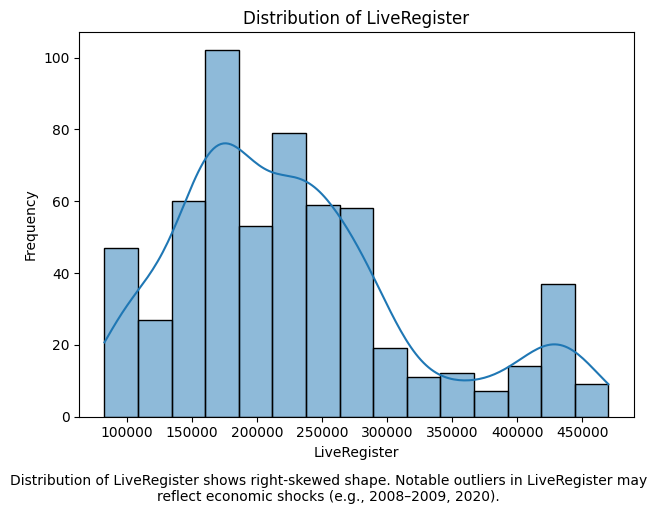

Remark for LiveRegister histogram: Distribution of LiveRegister shows right-skewed shape. Notable outliers in LiveRegister may reflect economic shocks (e.g., 2008–2009, 2020).


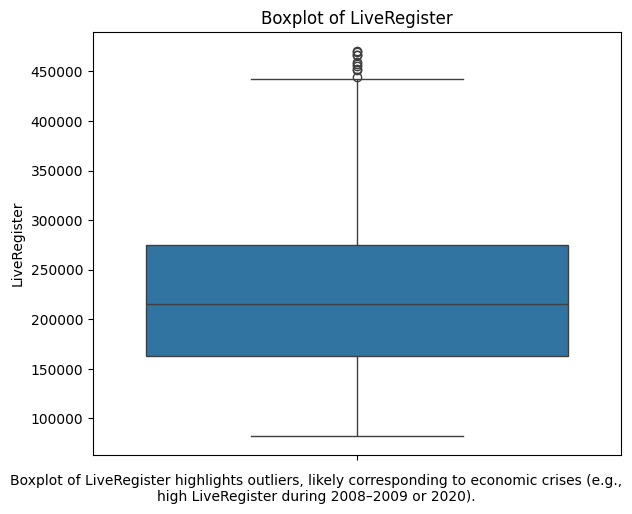

Remark for LiveRegister boxplot: Boxplot of LiveRegister highlights outliers, likely corresponding to economic crises (e.g., high LiveRegister during 2008–2009 or 2020).

JobseekRate_per100k:
count      579.000000
mean      5686.622821
std       2064.953526
min       2451.190547
25%       3763.213455
50%       5534.503425
75%       7274.648605
max      10279.656386
Name: JobseekRate_per100k, dtype: float64


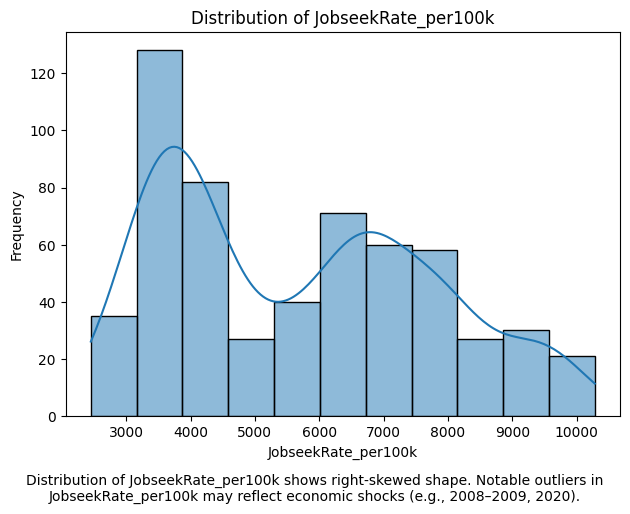

Remark for JobseekRate_per100k histogram: Distribution of JobseekRate_per100k shows right-skewed shape. Notable outliers in JobseekRate_per100k may reflect economic shocks (e.g., 2008–2009, 2020).


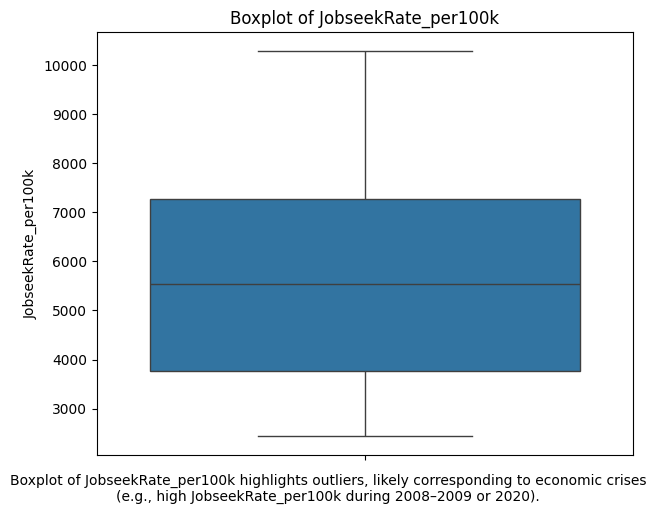

Remark for JobseekRate_per100k boxplot: Boxplot of JobseekRate_per100k highlights outliers, likely corresponding to economic crises (e.g., high JobseekRate_per100k during 2008–2009 or 2020).

UnemploymentRate:
count    594.000000
mean       5.655582
std        2.040852
min        2.542407
25%        3.810757
50%        5.382720
75%        7.182427
max        9.764547
Name: UnemploymentRate, dtype: float64


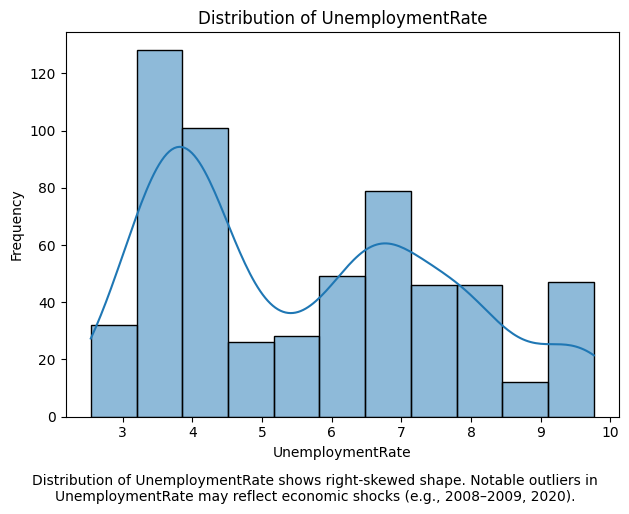

Remark for UnemploymentRate histogram: Distribution of UnemploymentRate shows right-skewed shape. Notable outliers in UnemploymentRate may reflect economic shocks (e.g., 2008–2009, 2020).


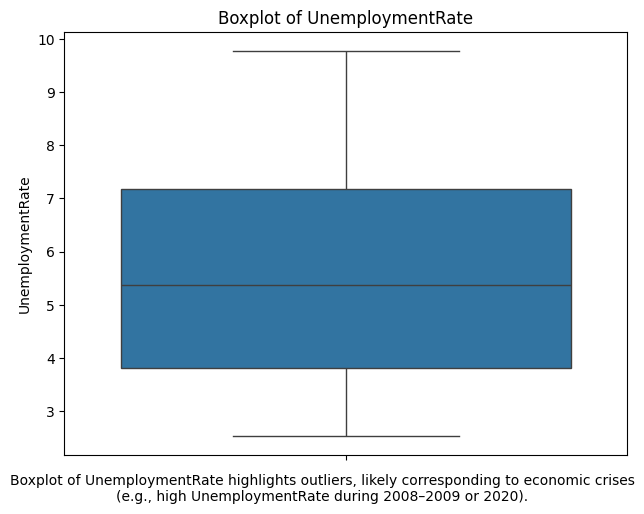

Remark for UnemploymentRate boxplot: Boxplot of UnemploymentRate highlights outliers, likely corresponding to economic crises (e.g., high UnemploymentRate during 2008–2009 or 2020).

CPI:
count    594.000000
mean      61.346465
std       23.447825
min       12.300000
25%       44.550000
50%       62.400000
75%       82.700000
max      102.600000
Name: CPI, dtype: float64


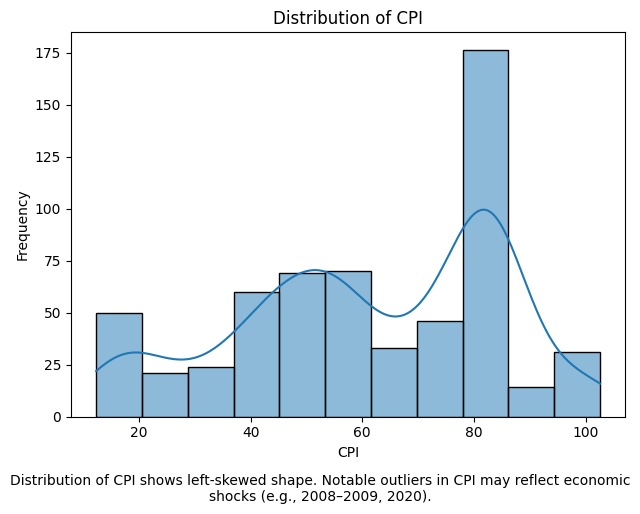

Remark for CPI histogram: Distribution of CPI shows left-skewed shape. Notable outliers in CPI may reflect economic shocks (e.g., 2008–2009, 2020).


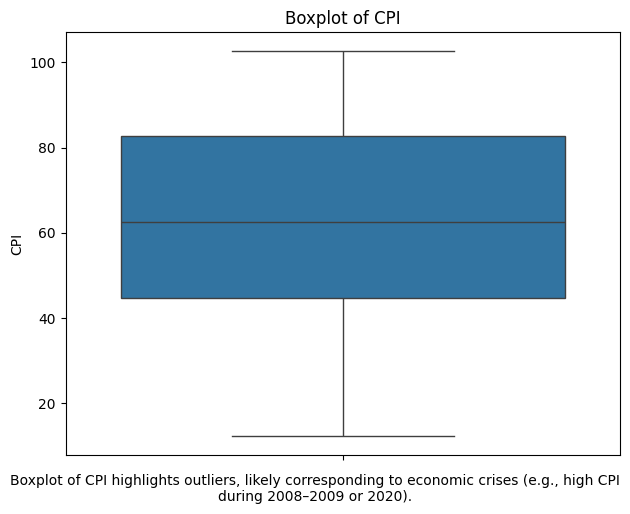

Remark for CPI boxplot: Boxplot of CPI highlights outliers, likely corresponding to economic crises (e.g., high CPI during 2008–2009 or 2020).

GDP:
count       591.000000
mean      36154.407228
std       25959.791899
min        8911.523321
25%       13576.246596
50%       31247.400000
75%       44444.800000
max      110256.900000
Name: GDP, dtype: float64


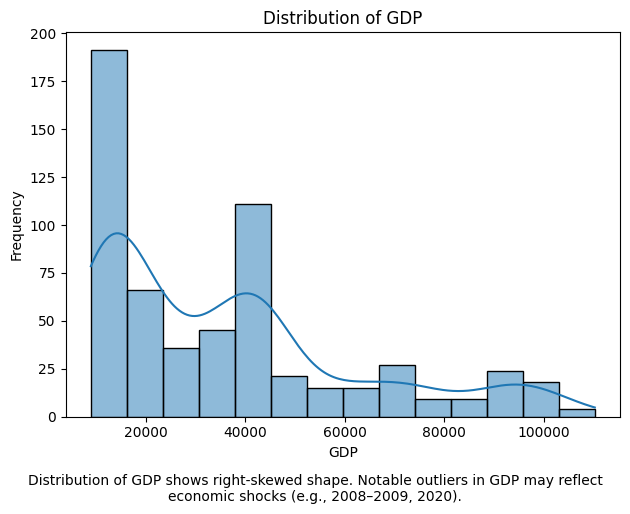

Remark for GDP histogram: Distribution of GDP shows right-skewed shape. Notable outliers in GDP may reflect economic shocks (e.g., 2008–2009, 2020).


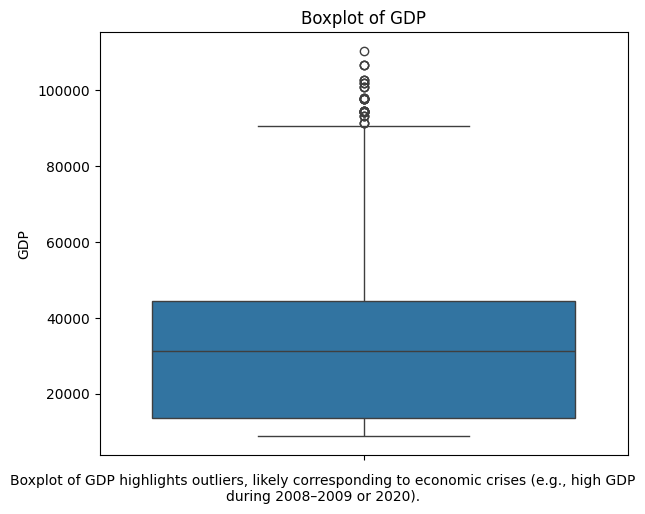

Remark for GDP boxplot: Boxplot of GDP highlights outliers, likely corresponding to economic crises (e.g., high GDP during 2008–2009 or 2020).

Population:
count    5.790000e+02
mean     4.025747e+06
std      6.036828e+05
min      3.177200e+06
25%      3.529000e+06
50%      3.741600e+06
75%      4.584300e+06
max      5.380300e+06
Name: Population, dtype: float64


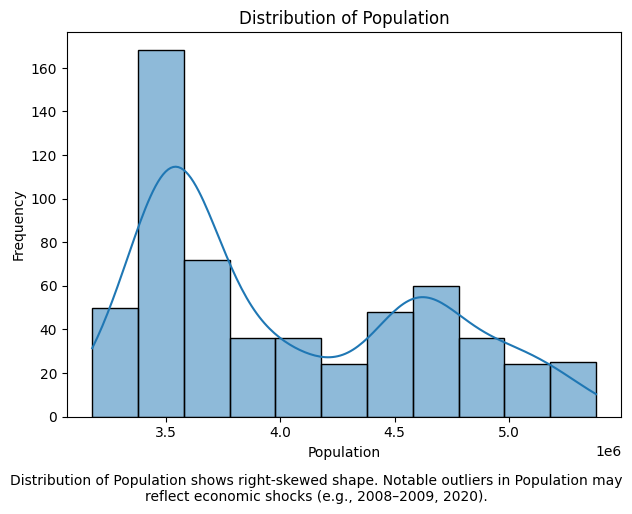

Remark for Population histogram: Distribution of Population shows right-skewed shape. Notable outliers in Population may reflect economic shocks (e.g., 2008–2009, 2020).


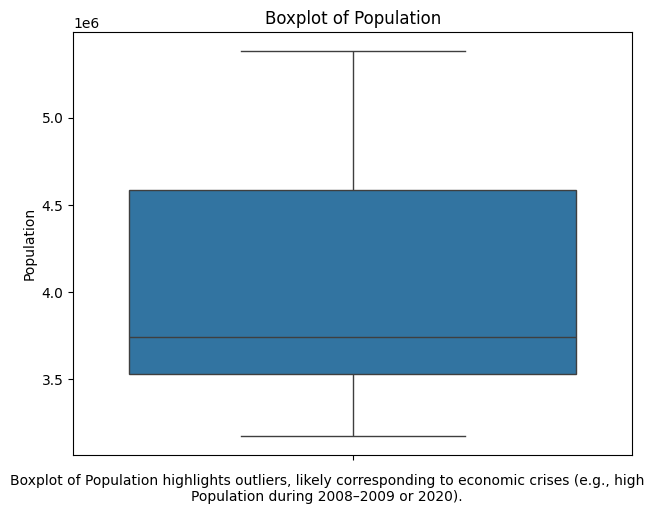

Remark for Population boxplot: Boxplot of Population highlights outliers, likely corresponding to economic crises (e.g., high Population during 2008–2009 or 2020).

PUP_Count:
count    2.500000e+01
mean     1.187143e+06
std      8.026841e+05
min      1.890140e+05
25%      4.612580e+05
50%      1.030962e+06
75%      1.774329e+06
max      2.962907e+06
Name: PUP_Count, dtype: float64


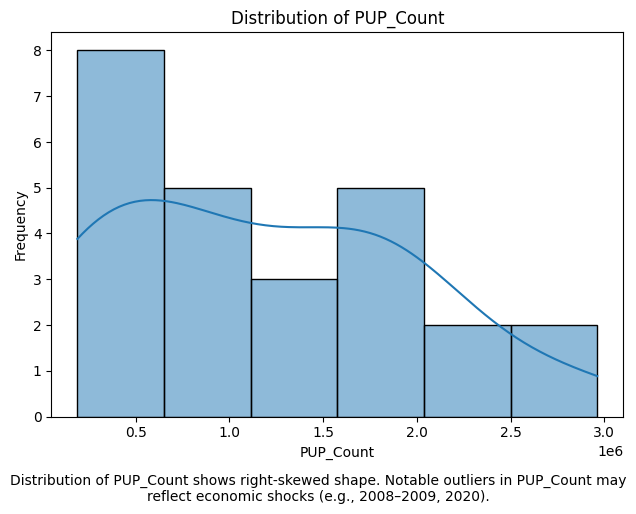

Remark for PUP_Count histogram: Distribution of PUP_Count shows right-skewed shape. Notable outliers in PUP_Count may reflect economic shocks (e.g., 2008–2009, 2020).


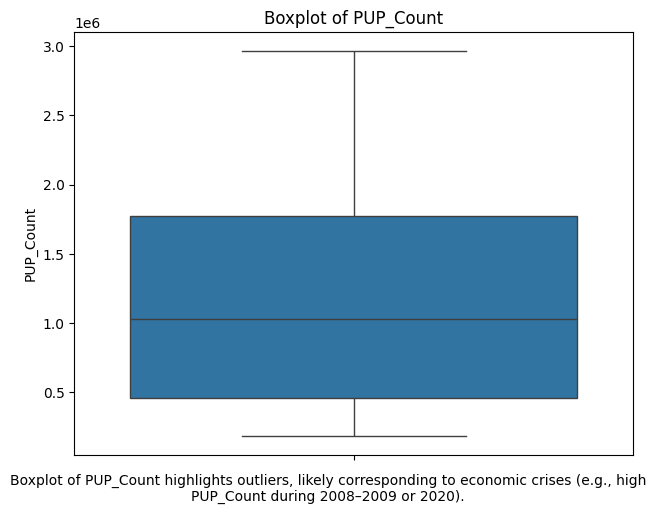

Remark for PUP_Count boxplot: Boxplot of PUP_Count highlights outliers, likely corresponding to economic crises (e.g., high PUP_Count during 2008–2009 or 2020).

WSS_Recipients:
count    5.940000e+02
mean     4.178862e+04
std      1.995966e+05
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.514492e+06
Name: WSS_Recipients, dtype: float64


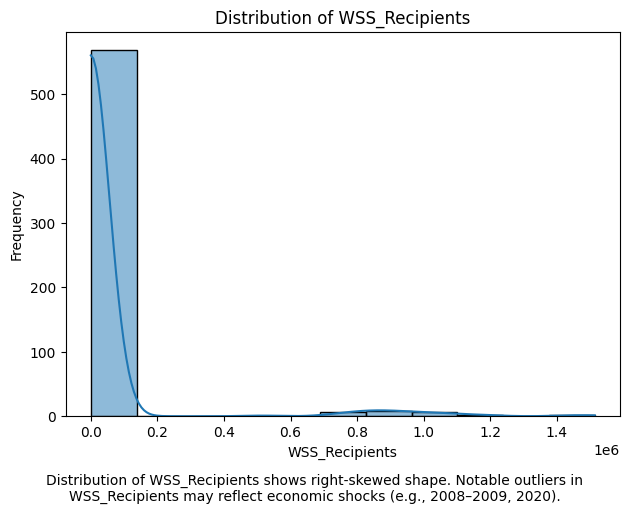

Remark for WSS_Recipients histogram: Distribution of WSS_Recipients shows right-skewed shape. Notable outliers in WSS_Recipients may reflect economic shocks (e.g., 2008–2009, 2020).


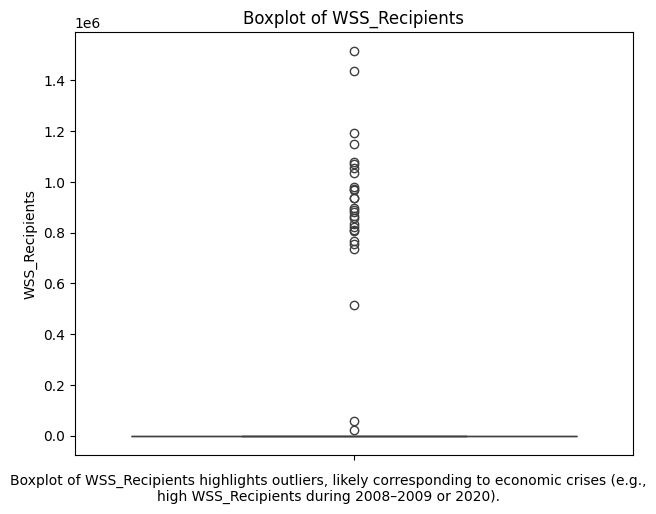

Remark for WSS_Recipients boxplot: Boxplot of WSS_Recipients highlights outliers, likely corresponding to economic crises (e.g., high WSS_Recipients during 2008–2009 or 2020).


In [ ]:
# Univariate Analysis
def univariate_analysis(df, cols):
    print("\nUnivariate Analysis - Summary Statistics and Remarks:")
    for col in cols:
        print(f"\n{col}:")
        print(df[col].describe())

        # Histogram
        plt.figure()
        sns.histplot(df[col].dropna(), kde=True)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        remark = f"Distribution of {col} shows {'right-skewed' if df[col].skew() > 0 else 'left-skewed'} shape. Notable outliers in {col} may reflect economic shocks (e.g., 2008–2009, 2020)."
        plt.figtext(0.5, -0.05, remark, wrap=True, horizontalalignment='center', fontsize=10)
        plt.tight_layout()
        plt.show()
        print(f"Remark for {col} histogram: {remark}")

        # Boxplot
        plt.figure()
        sns.boxplot(y=df[col].dropna())
        plt.title(f'Boxplot of {col}')
        plt.ylabel(col)
        remark = f"Boxplot of {col} highlights outliers, likely corresponding to economic crises (e.g., high {col} during 2008–2009 or 2020)."
        plt.figtext(0.5, -0.05, remark, wrap=True, horizontalalignment='center', fontsize=10)
        plt.tight_layout()
        plt.show()
        print(f"Remark for {col} boxplot: {remark}")

univariate_analysis(df, numeric_cols)

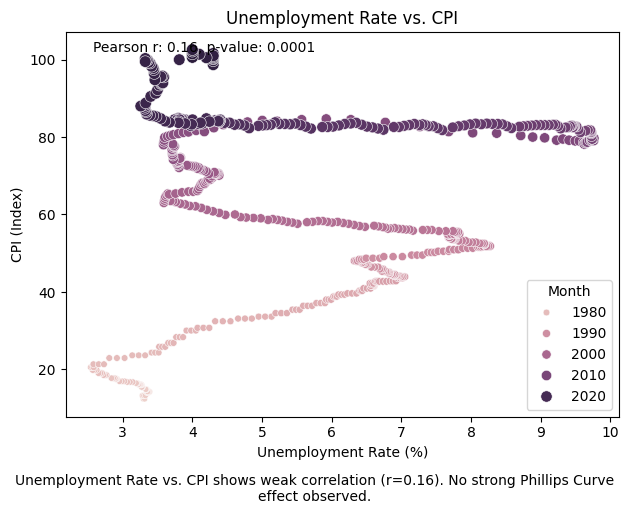

Remark for Unemployment Rate vs. CPI scatter: Unemployment Rate vs. CPI shows weak correlation (r=0.16). No strong Phillips Curve effect observed.


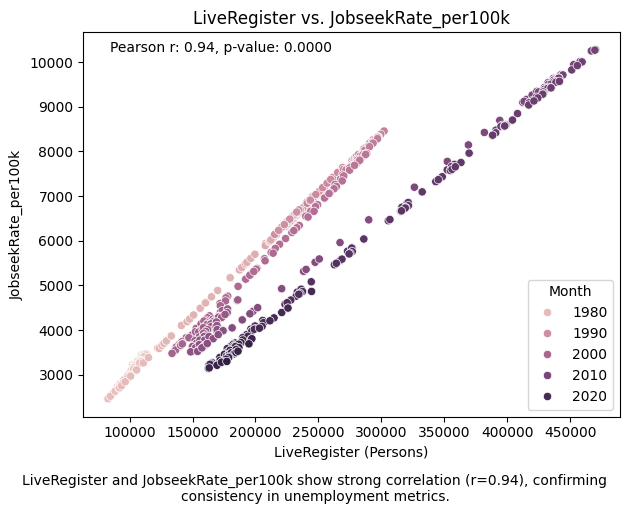

Remark for LiveRegister vs. JobseekRate_per100k scatter: LiveRegister and JobseekRate_per100k show strong correlation (r=0.94), confirming consistency in unemployment metrics.


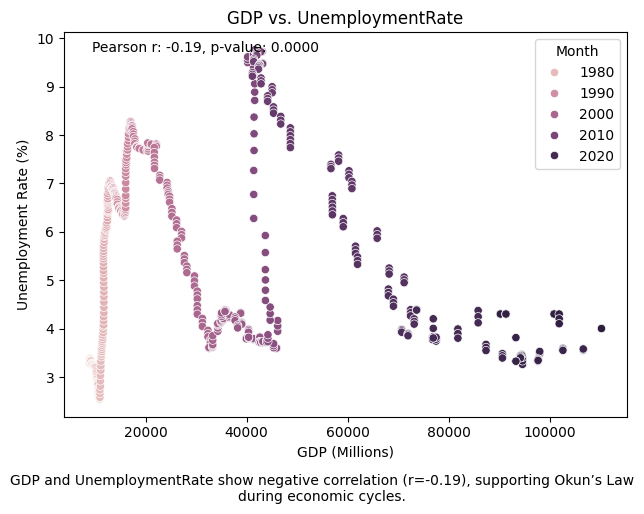

Remark for GDP vs. UnemploymentRate scatter: GDP and UnemploymentRate show negative correlation (r=-0.19), supporting Okun’s Law during economic cycles.


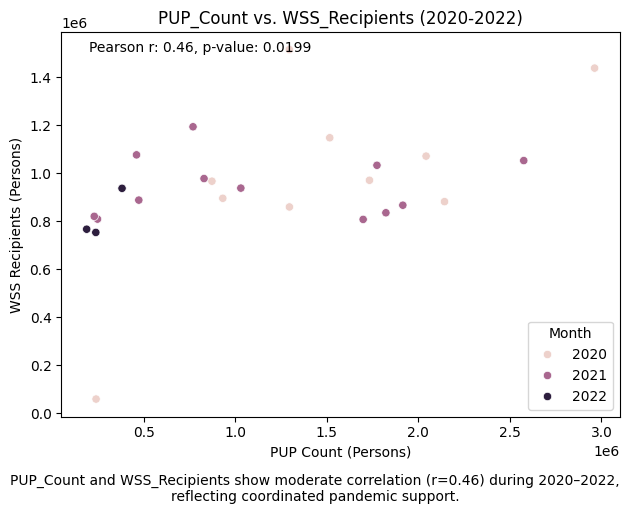

Remark for PUP_Count vs. WSS_Recipients scatter: PUP_Count and WSS_Recipients show moderate correlation (r=0.46) during 2020–2022, reflecting coordinated pandemic support.


In [ ]:
# Bivariate Analysis
def bivariate_analysis(df):
    # UnemploymentRate vs. CPI
    plt.figure()
    sns.scatterplot(data=df, x='UnemploymentRate', y='CPI', hue=df['Month'].dt.year, size=df['Month'].dt.year)
    plt.title('Unemployment Rate vs. CPI')
    plt.xlabel('Unemployment Rate (%)')
    plt.ylabel('CPI (Index)')
    valid_data = df[['UnemploymentRate', 'CPI']].dropna()
    if len(valid_data) > 1:
        corr, p_value = pearsonr(valid_data['UnemploymentRate'], valid_data['CPI'])
        plt.text(0.05, 0.95, f'Pearson r: {corr:.2f}, p-value: {p_value:.4f}', transform=plt.gca().transAxes)
        remark = f"Unemployment Rate vs. CPI shows {'weak' if abs(corr) < 0.3 else 'moderate'} correlation (r={corr:.2f}). No strong Phillips Curve effect observed."
    else:
        remark = "Insufficient data for Unemployment Rate vs. CPI correlation."
    plt.figtext(0.5, -0.05, remark, wrap=True, horizontalalignment='center', fontsize=10)
    plt.tight_layout()
    plt.show()
    print(f"Remark for Unemployment Rate vs. CPI scatter: {remark}")

    # LiveRegister vs. JobseekRate_per100k
    plt.figure()
    sns.scatterplot(data=df, x='LiveRegister', y='JobseekRate_per100k', hue=df['Month'].dt.year)
    plt.title('LiveRegister vs. JobseekRate_per100k')
    plt.xlabel('LiveRegister (Persons)')
    plt.ylabel('JobseekRate_per100k')
    valid_data = df[['LiveRegister', 'JobseekRate_per100k']].dropna()
    if len(valid_data) > 1:
        corr, p_value = pearsonr(valid_data['LiveRegister'], valid_data['JobseekRate_per100k'])
        plt.text(0.05, 0.95, f'Pearson r: {corr:.2f}, p-value: {p_value:.4f}', transform=plt.gca().transAxes)
        remark = f"LiveRegister and JobseekRate_per100k show {'strong' if abs(corr) > 0.7 else 'moderate'} correlation (r={corr:.2f}), confirming consistency in unemployment metrics."
    else:
        remark = "Insufficient data for LiveRegister vs. JobseekRate_per100k correlation."
    plt.figtext(0.5, -0.05, remark, wrap=True, horizontalalignment='center', fontsize=10)
    plt.tight_layout()
    plt.show()
    print(f"Remark for LiveRegister vs. JobseekRate_per100k scatter: {remark}")

    # GDP vs. UnemploymentRate
    plt.figure()
    sns.scatterplot(data=df, x='GDP', y='UnemploymentRate', hue=df['Month'].dt.year)
    plt.title('GDP vs. UnemploymentRate')
    plt.xlabel('GDP (Millions)')
    plt.ylabel('Unemployment Rate (%)')
    valid_data = df[['GDP', 'UnemploymentRate']].dropna()
    if len(valid_data) > 1:
        corr, p_value = pearsonr(valid_data['GDP'], valid_data['UnemploymentRate'])
        plt.text(0.05, 0.95, f'Pearson r: {corr:.2f}, p-value: {p_value:.4f}', transform=plt.gca().transAxes)
        remark = f"GDP and UnemploymentRate show {'negative' if corr < 0 else 'positive'} correlation (r={corr:.2f}), supporting Okun’s Law during economic cycles."
    else:
        remark = "Insufficient data for GDP vs. UnemploymentRate correlation."
    plt.figtext(0.5, -0.05, remark, wrap=True, horizontalalignment='center', fontsize=10)
    plt.tight_layout()
    plt.show()
    print(f"Remark for GDP vs. UnemploymentRate scatter: {remark}")

    # PUP_Count vs. WSS_Recipients (2020-2022)
    pandemic_data = df[(df['Month'] >= '2020-01-01') & (df['Month'] <= '2022-12-31')]
    plt.figure()
    sns.scatterplot(data=pandemic_data, x='PUP_Count', y='WSS_Recipients', hue=pandemic_data['Month'].dt.year)
    plt.title('PUP_Count vs. WSS_Recipients (2020-2022)')
    plt.xlabel('PUP Count (Persons)')
    plt.ylabel('WSS Recipients (Persons)')
    valid_data = pandemic_data[['PUP_Count', 'WSS_Recipients']].dropna()
    if len(valid_data) > 1:
        corr, p_value = pearsonr(valid_data['PUP_Count'], valid_data['WSS_Recipients'])
        plt.text(0.05, 0.95, f'Pearson r: {corr:.2f}, p-value: {p_value:.4f}', transform=plt.gca().transAxes)
        remark = f"PUP_Count and WSS_Recipients show {'strong' if abs(corr) > 0.7 else 'moderate'} correlation (r={corr:.2f}) during 2020–2022, reflecting coordinated pandemic support."
    else:
        remark = "Insufficient data for PUP_Count vs. WSS_Recipients correlation."
    plt.figtext(0.5, -0.05, remark, wrap=True, horizontalalignment='center', fontsize=10)
    plt.tight_layout()
    plt.show()
    print(f"Remark for PUP_Count vs. WSS_Recipients scatter: {remark}")

bivariate_analysis(df)

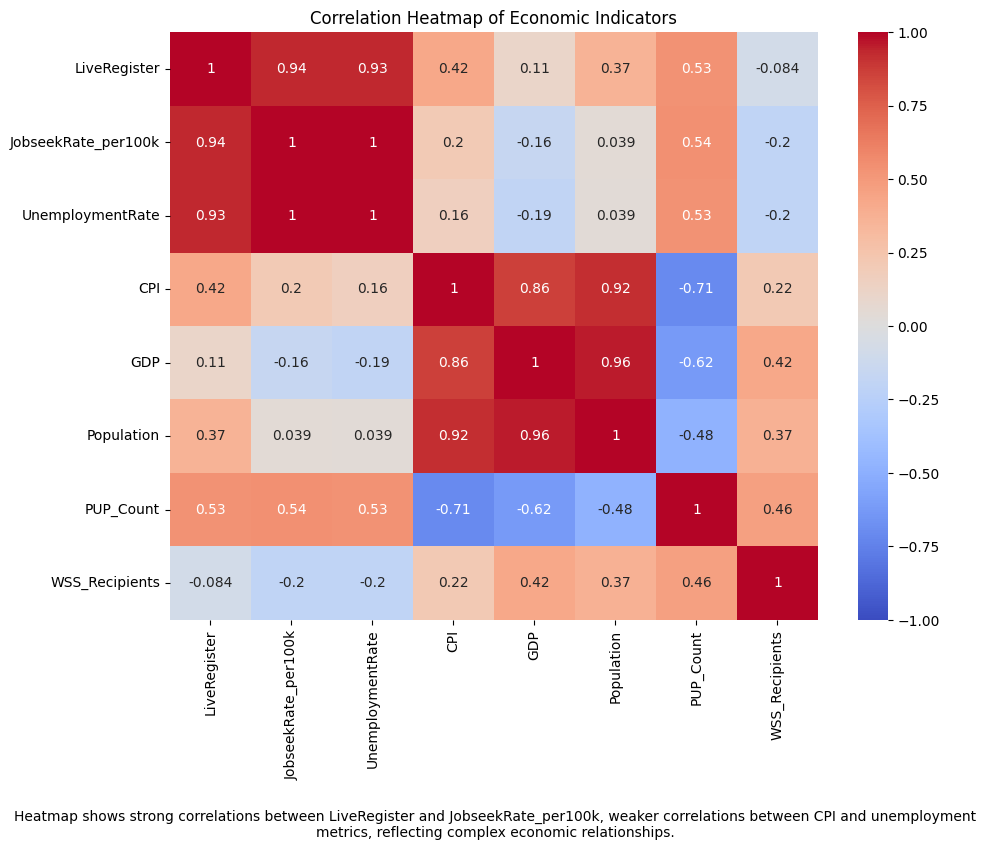

Remark for correlation heatmap: Heatmap shows strong correlations between LiveRegister and JobseekRate_per100k, weaker correlations between CPI and unemployment metrics, reflecting complex economic relationships.
Remark for pair plot: Pair plot reveals pairwise relationships; UnemploymentRate and GDP show negative trends, while CPI increases steadily, with clusters during economic crises.


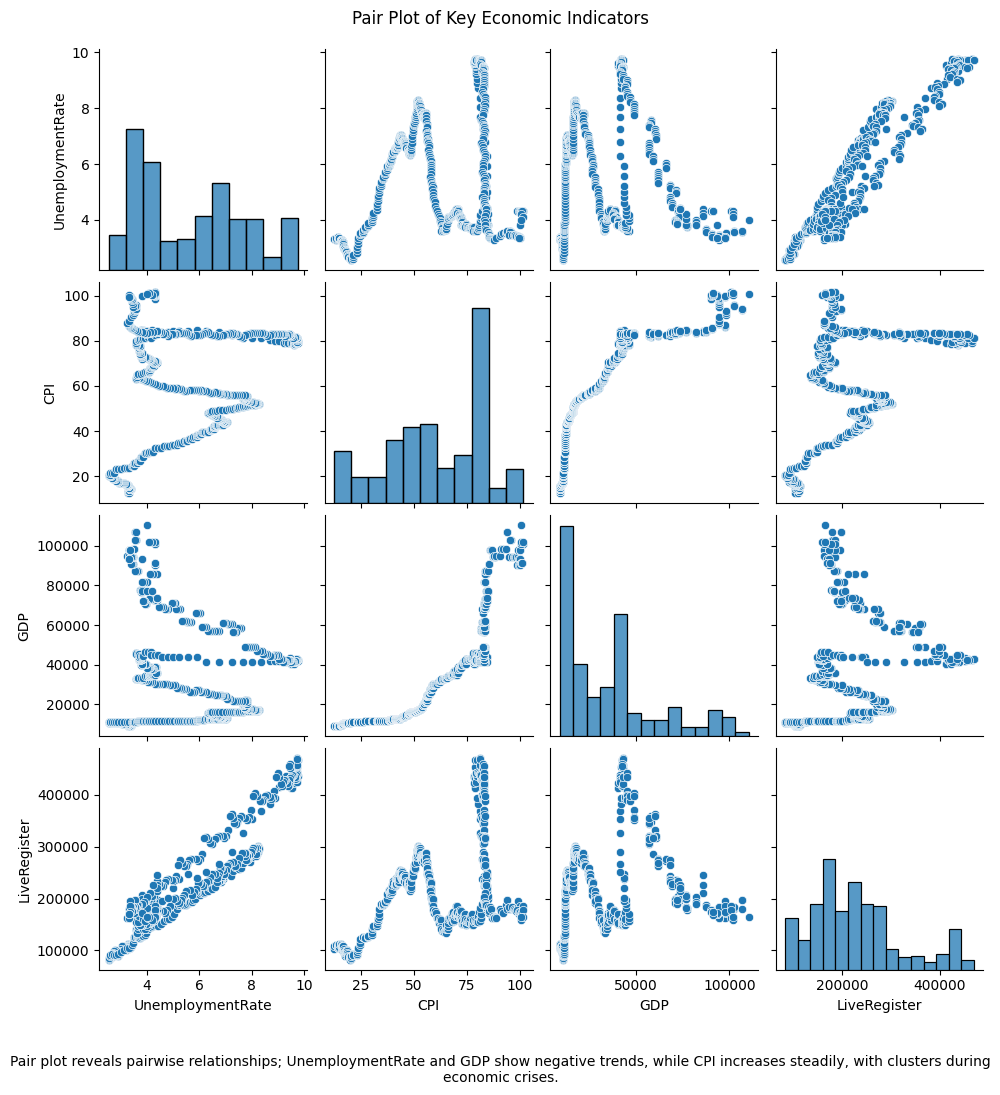

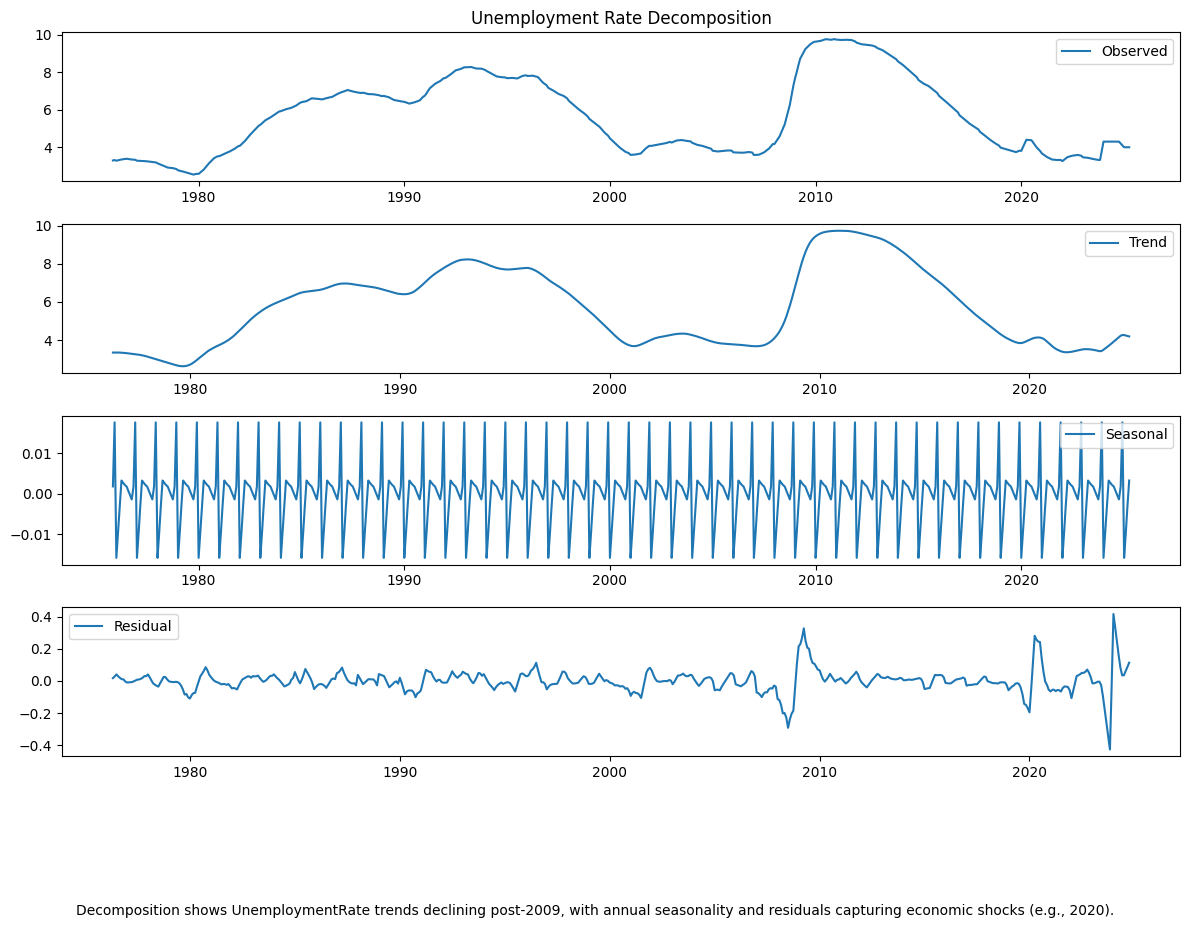

Remark for unemployment decomposition: Decomposition shows UnemploymentRate trends declining post-2009, with annual seasonality and residuals capturing economic shocks (e.g., 2020).


In [ ]:
# Multivariate Analysis
def multivariate_analysis(df):
    # Correlation Heatmap
    plt.figure(figsize=(10, 8))
    corr_matrix = df[numeric_cols].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Heatmap of Economic Indicators')
    remark = "Heatmap shows strong correlations between LiveRegister and JobseekRate_per100k, weaker correlations between CPI and unemployment metrics, reflecting complex economic relationships."
    plt.figtext(0.5, -0.05, remark, wrap=True, horizontalalignment='center', fontsize=10)
    plt.tight_layout()
    plt.show()
    print(f"Remark for correlation heatmap: {remark}")

    # Pair Plot (subset for performance)
    pair_plot = sns.pairplot(df[['UnemploymentRate', 'CPI', 'GDP', 'LiveRegister']].dropna())
    pair_plot.fig.suptitle('Pair Plot of Key Economic Indicators', y=1.02)
    remark = "Pair plot reveals pairwise relationships; UnemploymentRate and GDP show negative trends, while CPI increases steadily, with clusters during economic crises."
    pair_plot.fig.text(0.5, -0.05, remark, wrap=True, horizontalalignment='center', fontsize=10)
    pair_plot.fig.show()
    print(f"Remark for pair plot: {remark}")

    # Time Series Decomposition for UnemploymentRate
    ts_data = df.set_index('Month')['UnemploymentRate'].dropna()
    decomposition = seasonal_decompose(ts_data, model='additive', period=12)

    plt.figure(figsize=(12, 8))
    plt.subplot(411)
    plt.plot(decomposition.observed, label='Observed')
    plt.title('Unemployment Rate Decomposition')
    plt.legend()

    plt.subplot(412)
    plt.plot(decomposition.trend, label='Trend')
    plt.legend()

    plt.subplot(413)
    plt.plot(decomposition.seasonal, label='Seasonal')
    plt.legend()

    plt.subplot(414)
    plt.plot(decomposition.resid, label='Residual')
    plt.legend()

    remark = "Decomposition shows UnemploymentRate trends declining post-2009, with annual seasonality and residuals capturing economic shocks (e.g., 2020)."
    plt.figtext(0.5, -0.15, remark, wrap=True, horizontalalignment='center', fontsize=10)
    plt.tight_layout()
    plt.show()
    print(f"Remark for unemployment decomposition: {remark}")

multivariate_analysis(df)


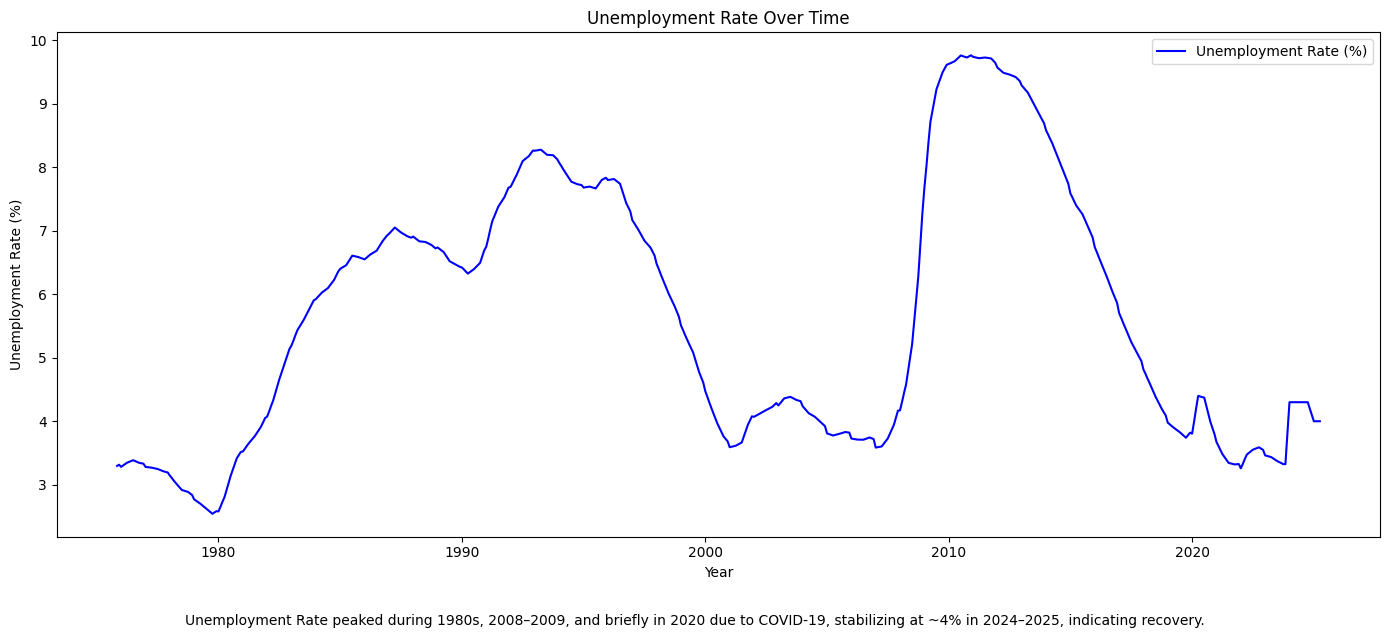

Remark for Unemployment Rate time series: Unemployment Rate peaked during 1980s, 2008–2009, and briefly in 2020 due to COVID-19, stabilizing at ~4% in 2024–2025, indicating recovery.


<Figure size 1400x600 with 0 Axes>

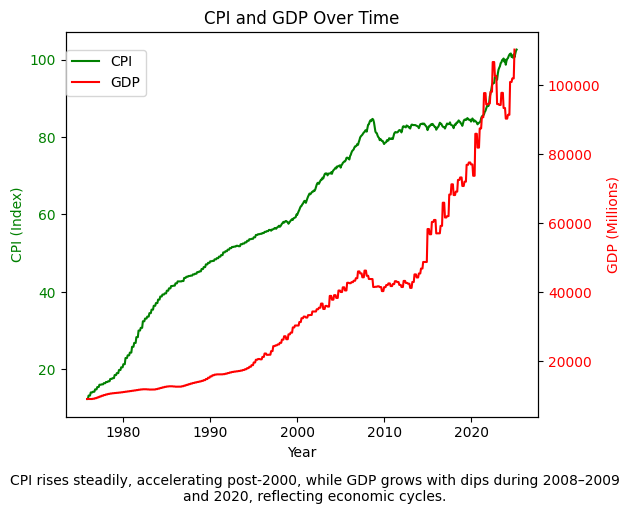

Remark for CPI and GDP time series: CPI rises steadily, accelerating post-2000, while GDP grows with dips during 2008–2009 and 2020, reflecting economic cycles.


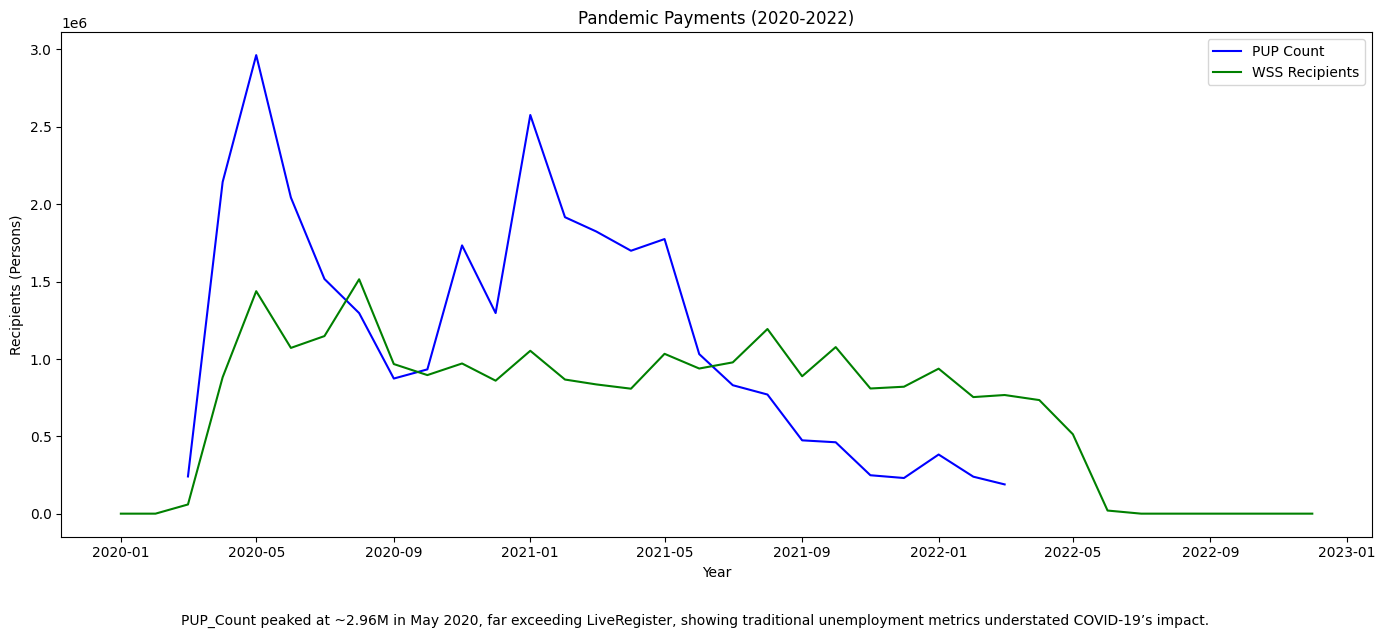

Remark for Pandemic Payments time series: PUP_Count peaked at ~2.96M in May 2020, far exceeding LiveRegister, showing traditional unemployment metrics understated COVID-19’s impact.


In [ ]:
# Time Series Plots
def time_series_plots(df):
    # UnemploymentRate
    plt.figure(figsize=(14, 6))
    plt.plot(df['Month'], df['UnemploymentRate'], label='Unemployment Rate (%)', color='blue')
    plt.title('Unemployment Rate Over Time')
    plt.xlabel('Year')
    plt.ylabel('Unemployment Rate (%)')
    plt.legend()
    remark = "Unemployment Rate peaked during 1980s, 2008–2009, and briefly in 2020 due to COVID-19, stabilizing at ~4% in 2024–2025, indicating recovery."
    plt.figtext(0.5, -0.05, remark, wrap=True, horizontalalignment='center', fontsize=10)
    plt.tight_layout()
    plt.show()
    print(f"Remark for Unemployment Rate time series: {remark}")

    # CPI and GDP
    plt.figure(figsize=(14, 6))
    fig, ax1 = plt.subplots()
    ax1.plot(df['Month'], df['CPI'], label='CPI', color='green')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('CPI (Index)', color='green')
    ax1.tick_params(axis='y', labelcolor='green')

    ax2 = ax1.twinx()
    ax2.plot(df['Month'], df['GDP'], label='GDP', color='red')
    ax2.set_ylabel('GDP (Millions)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    plt.title('CPI and GDP Over Time')
    fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))
    remark = "CPI rises steadily, accelerating post-2000, while GDP grows with dips during 2008–2009 and 2020, reflecting economic cycles."
    plt.figtext(0.5, -0.05, remark, wrap=True, horizontalalignment='center', fontsize=10)
    plt.tight_layout()
    plt.show()
    print(f"Remark for CPI and GDP time series: {remark}")

    # PUP_Count and WSS_Recipients (2020-2022)
    pandemic_data = df[(df['Month'] >= '2020-01-01') & (df['Month'] <= '2022-12-31')]
    plt.figure(figsize=(14, 6))
    plt.plot(pandemic_data['Month'], pandemic_data['PUP_Count'], label='PUP Count', color='blue')
    plt.plot(pandemic_data['Month'], pandemic_data['WSS_Recipients'], label='WSS Recipients', color='green')
    plt.title('Pandemic Payments (2020-2022)')
    plt.xlabel('Year')
    plt.ylabel('Recipients (Persons)')
    plt.legend()
    remark = "PUP_Count peaked at ~2.96M in May 2020, far exceeding LiveRegister, showing traditional unemployment metrics understated COVID-19’s impact."
    plt.figtext(0.5, -0.05, remark, wrap=True, horizontalalignment='center', fontsize=10)
    plt.tight_layout()
    plt.show()
    print(f"Remark for Pandemic Payments time series: {remark}")

time_series_plots(df)


/tmp/ipython-input-53-337050716.py:20: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['UnemploymentRate'].dropna(), shade=True, label='KDE')


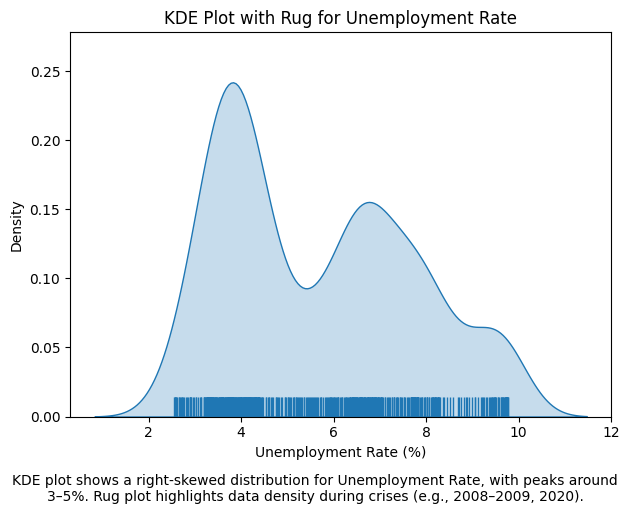

Remark for Unemployment Rate KDE: KDE plot shows a right-skewed distribution for Unemployment Rate, with peaks around 3–5%. Rug plot highlights data density during crises (e.g., 2008–2009, 2020).


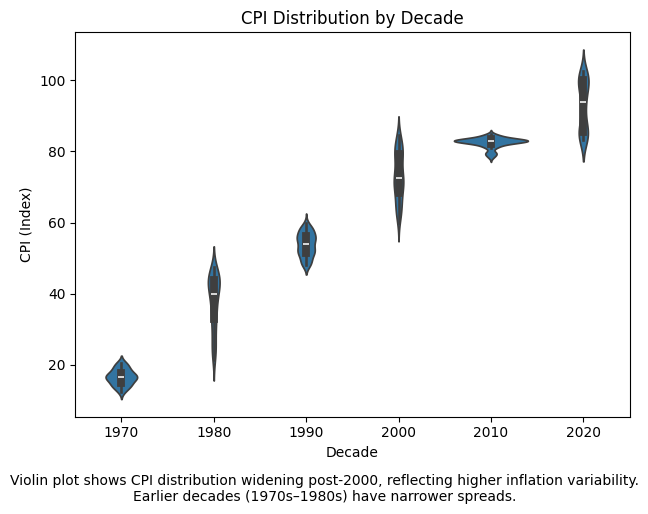

Remark for CPI violin plot: Violin plot shows CPI distribution widening post-2000, reflecting higher inflation variability. Earlier decades (1970s–1980s) have narrower spreads.


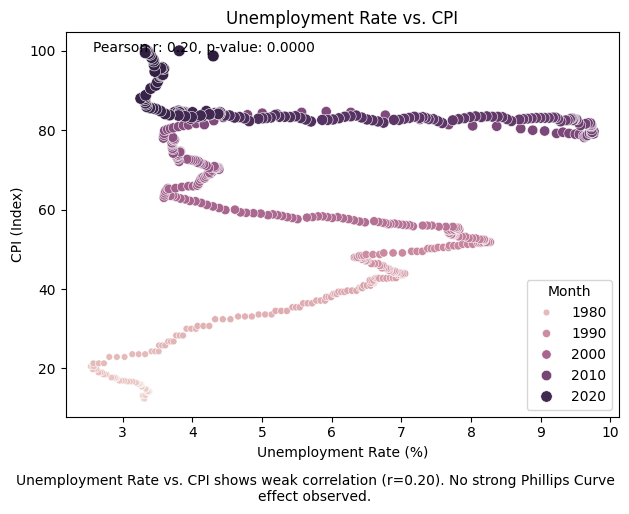

Remark for Unemployment Rate vs. CPI scatter: Unemployment Rate vs. CPI shows weak correlation (r=0.20). No strong Phillips Curve effect observed.


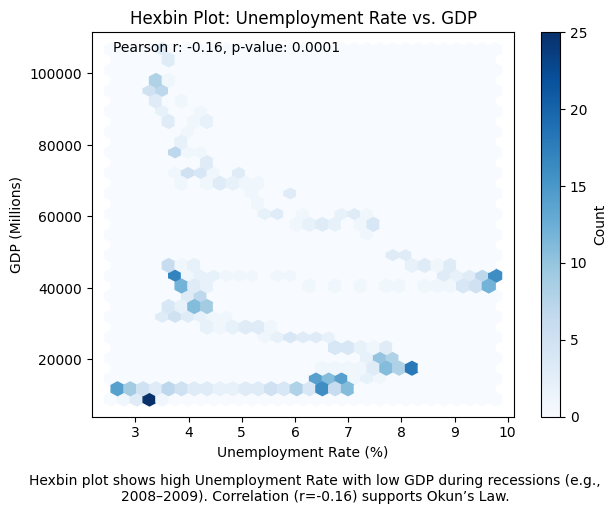

Remark for Unemployment Rate vs. GDP hexbin: Hexbin plot shows high Unemployment Rate with low GDP during recessions (e.g., 2008–2009). Correlation (r=-0.16) supports Okun’s Law.


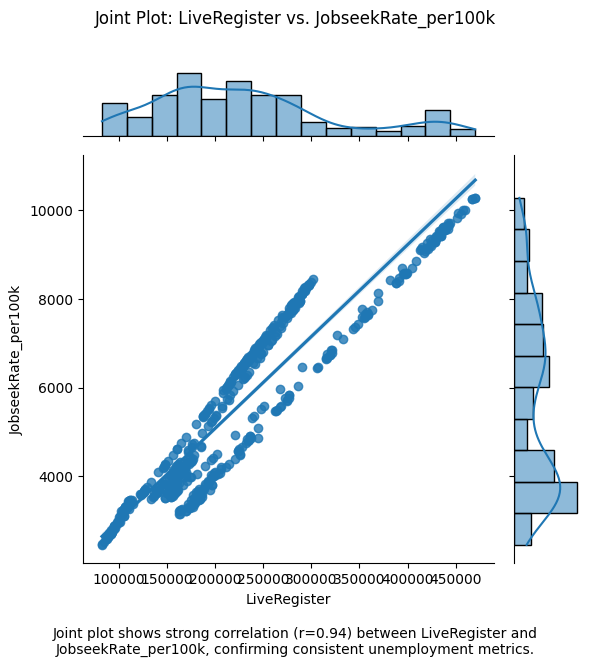

Remark for LiveRegister vs. JobseekRate_per100k joint plot: Joint plot shows strong correlation (r=0.94) between LiveRegister and JobseekRate_per100k, confirming consistent unemployment metrics.


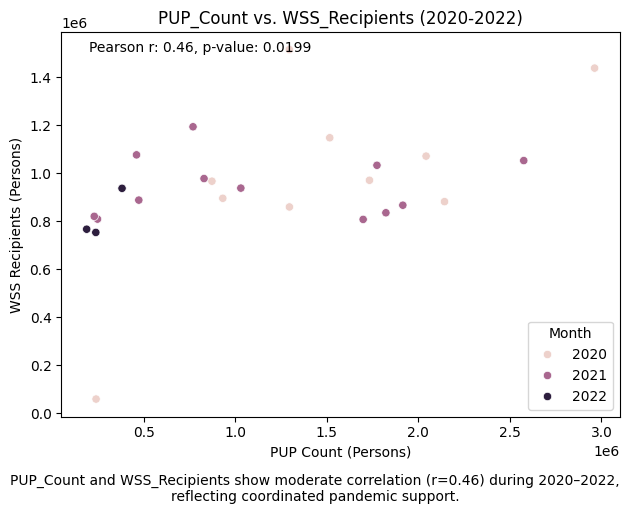

Remark for PUP_Count vs. WSS_Recipients scatter: PUP_Count and WSS_Recipients show moderate correlation (r=0.46) during 2020–2022, reflecting coordinated pandemic support.


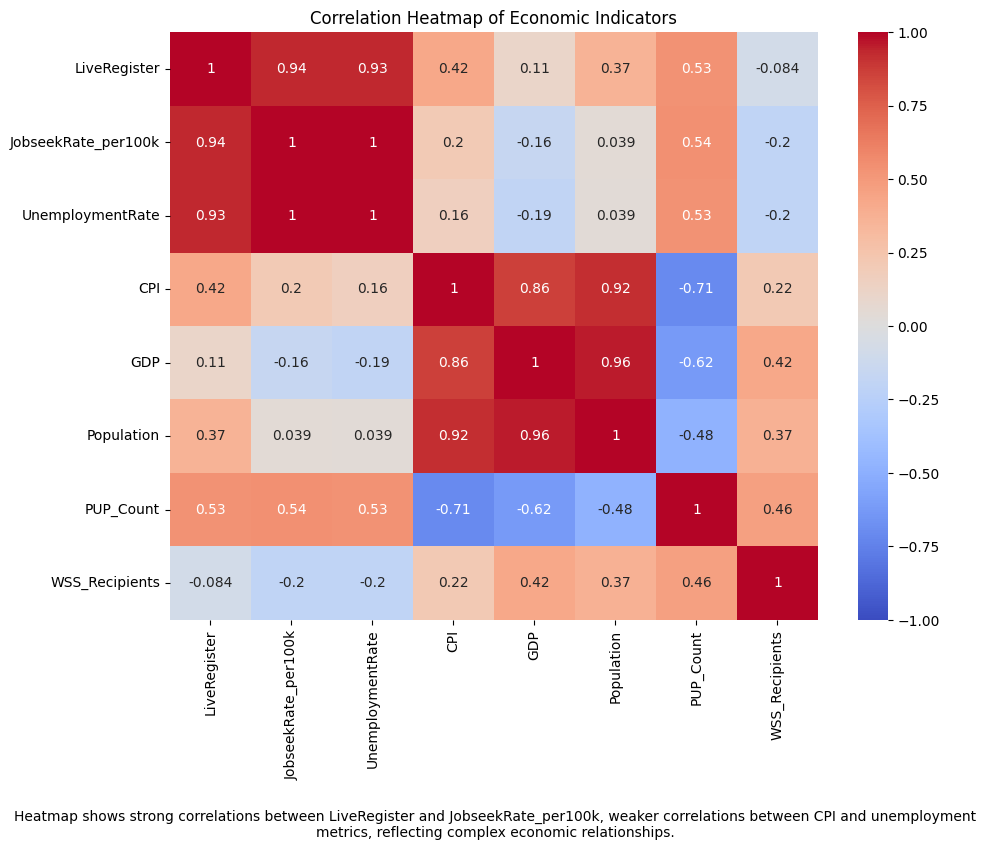

Remark for correlation heatmap: Heatmap shows strong correlations between LiveRegister and JobseekRate_per100k, weaker correlations between CPI and unemployment metrics, reflecting complex economic relationships.


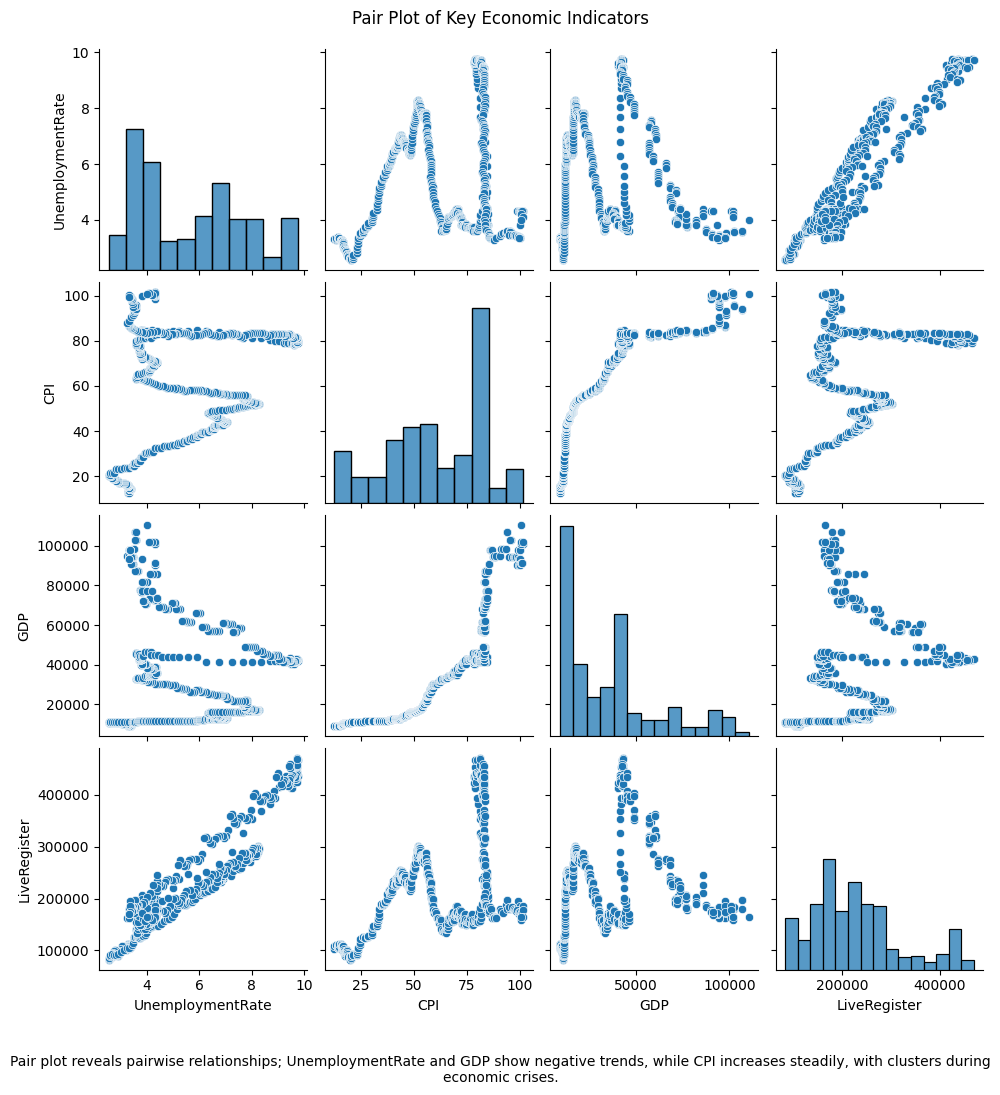

Remark for pair plot: Pair plot reveals pairwise relationships; UnemploymentRate and GDP show negative trends, while CPI increases steadily, with clusters during economic crises.


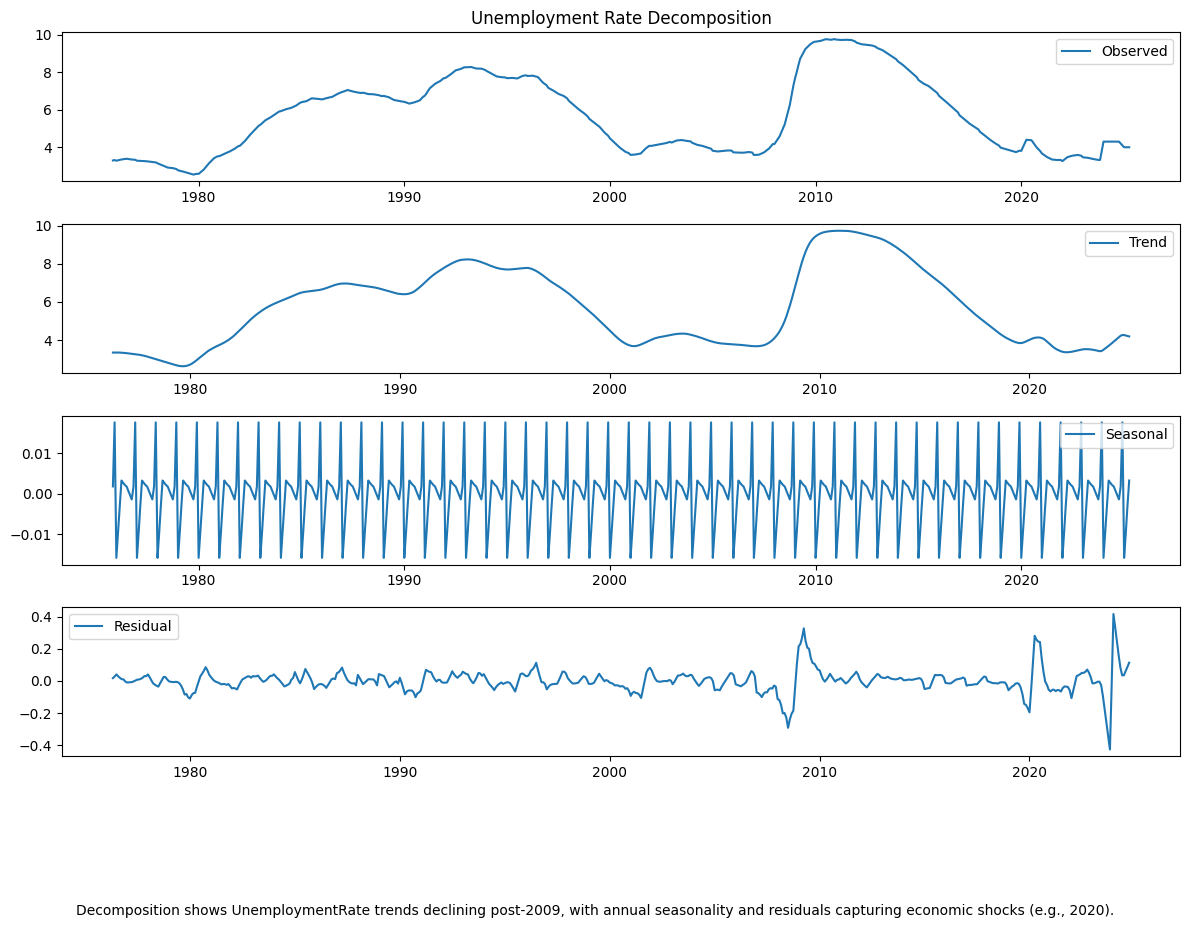

Remark for unemployment decomposition: Decomposition shows UnemploymentRate trends declining post-2009, with annual seasonality and residuals capturing economic shocks (e.g., 2020).


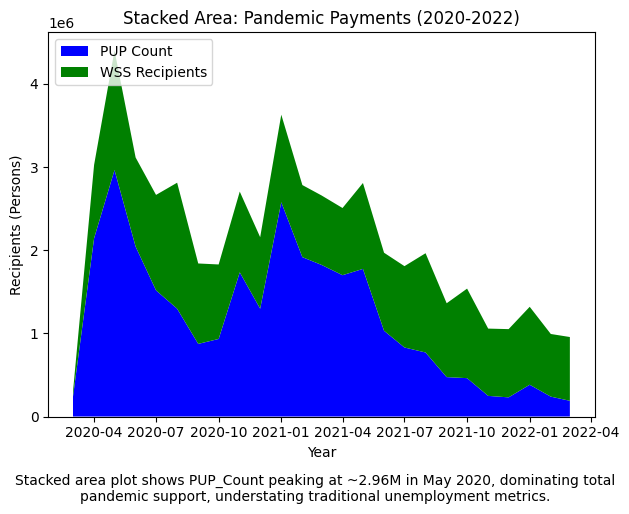

Remark for Pandemic Payments stacked area: Stacked area plot shows PUP_Count peaking at ~2.96M in May 2020, dominating total pandemic support, understating traditional unemployment metrics.


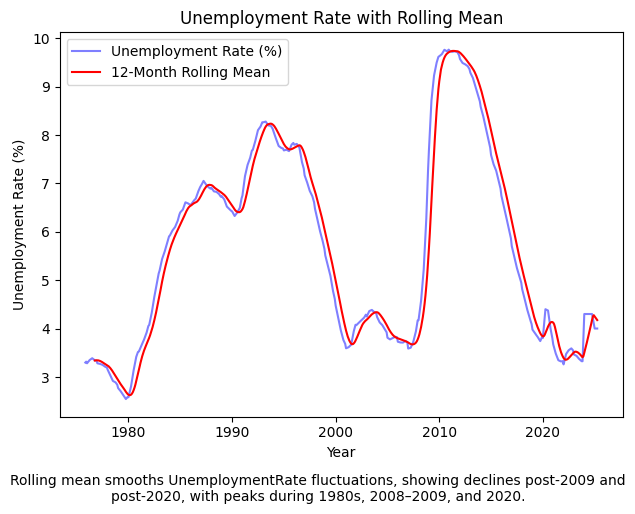

Remark for Unemployment Rate rolling mean: Rolling mean smooths UnemploymentRate fluctuations, showing declines post-2009 and post-2020, with peaks during 1980s, 2008–2009, and 2020.


In [ ]:
from pandas.plotting import parallel_coordinates, lag_plot
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from statsmodels.tsa.seasonal import seasonal_decompose
import os
from datetime import datetime
import pandas as pd # Import pandas

# Add Year column for yearly aggregation
df['Year'] = df['Month'].dt.year

# Univariate Analysis
def univariate_analysis(df):
    # Add 'Decade' column
    df['Decade'] = (df['Year'] // 10) * 10

    # KDE Plot with Rug for UnemploymentRate
    plt.figure()
    sns.kdeplot(df['UnemploymentRate'].dropna(), shade=True, label='KDE')
    sns.rugplot(df['UnemploymentRate'].dropna(), height=0.05)
    plt.title('KDE Plot with Rug for Unemployment Rate')
    plt.xlabel('Unemployment Rate (%)')
    plt.ylabel('Density')
    remark = "KDE plot shows a right-skewed distribution for Unemployment Rate, with peaks around 3–5%. Rug plot highlights data density during crises (e.g., 2008–2009, 2020)."
    plt.figtext(0.5, -0.05, remark, wrap=True, horizontalalignment='center', fontsize=10)
    plt.tight_layout()
    plt.show()
    print(f"Remark for Unemployment Rate KDE: {remark}")

    # Violin Plot for CPI by Decade
    plt.figure()
    sns.violinplot(x='Decade', y='CPI', data=df.dropna(subset=['CPI', 'Decade']))
    plt.title('CPI Distribution by Decade')
    plt.xlabel('Decade')
    plt.ylabel('CPI (Index)')
    remark = "Violin plot shows CPI distribution widening post-2000, reflecting higher inflation variability. Earlier decades (1970s–1980s) have narrower spreads."
    plt.figtext(0.5, -0.05, remark, wrap=True, horizontalalignment='center', fontsize=10)
    plt.tight_layout()
    plt.show()
    print(f"Remark for CPI violin plot: {remark}")

# Bivariate Analysis
def bivariate_analysis(df):
    # Drop rows with NaN in the relevant columns for bivariate analysis
    bivariate_data = df[['UnemploymentRate', 'GDP', 'LiveRegister', 'JobseekRate_per100k', 'CPI', 'Month', 'PUP_Count', 'WSS_Recipients']].dropna(subset=['UnemploymentRate', 'GDP', 'LiveRegister', 'JobseekRate_per100k', 'CPI'])

    # UnemploymentRate vs. CPI
    plt.figure()
    sns.scatterplot(data=bivariate_data, x='UnemploymentRate', y='CPI', hue=bivariate_data['Month'].dt.year, size=bivariate_data['Month'].dt.year)
    plt.title('Unemployment Rate vs. CPI')
    plt.xlabel('Unemployment Rate (%)')
    plt.ylabel('CPI (Index)')
    valid_data = bivariate_data[['UnemploymentRate', 'CPI']].dropna()
    if len(valid_data) > 1:
        corr, p_value = pearsonr(valid_data['UnemploymentRate'], valid_data['CPI'])
        plt.text(0.05, 0.95, f'Pearson r: {corr:.2f}, p-value: {p_value:.4f}', transform=plt.gca().transAxes)
        remark = f"Unemployment Rate vs. CPI shows {'weak' if abs(corr) < 0.3 else 'moderate'} correlation (r={corr:.2f}). No strong Phillips Curve effect observed."
    else:
        remark = "Insufficient data for Unemployment Rate vs. CPI correlation."
    plt.figtext(0.5, -0.05, remark, wrap=True, horizontalalignment='center', fontsize=10)
    plt.tight_layout()
    plt.show()
    print(f"Remark for Unemployment Rate vs. CPI scatter: {remark}")


    # Hexbin Plot for UnemploymentRate vs. GDP
    plt.figure()
    plt.hexbin(bivariate_data['UnemploymentRate'], bivariate_data['GDP'], gridsize=30, cmap='Blues')
    plt.colorbar(label='Count')
    plt.title('Hexbin Plot: Unemployment Rate vs. GDP')
    plt.xlabel('Unemployment Rate (%)')
    plt.ylabel('GDP (Millions)')
    valid_data = bivariate_data[['UnemploymentRate', 'GDP']].dropna()
    if len(valid_data) > 1:
        corr, p_value = pearsonr(valid_data['UnemploymentRate'], valid_data['GDP'])
        plt.text(0.05, 0.95, f'Pearson r: {corr:.2f}, p-value: {p_value:.4f}', transform=plt.gca().transAxes)
        remark = f"Hexbin plot shows high Unemployment Rate with low GDP during recessions (e.g., 2008–2009). Correlation (r={corr:.2f}) supports Okun’s Law."
    else:
        remark = "Insufficient data for Unemployment Rate vs. GDP hexbin plot."
    plt.figtext(0.5, -0.05, remark, wrap=True, horizontalalignment='center', fontsize=10)
    plt.tight_layout()
    plt.show()
    print(f"Remark for Unemployment Rate vs. GDP hexbin: {remark}")

    # Joint Plot for LiveRegister vs. JobseekRate_per100k
    valid_data = bivariate_data[['LiveRegister', 'JobseekRate_per100k']].dropna()
    if len(valid_data) > 0:
        joint_plot = sns.jointplot(data=valid_data, x='LiveRegister', y='JobseekRate_per100k', kind='reg')
        corr, p_value = pearsonr(valid_data['LiveRegister'], valid_data['JobseekRate_per100k'])
        remark = f"Joint plot shows strong correlation (r={corr:.2f}) between LiveRegister and JobseekRate_per100k, confirming consistent unemployment metrics."
        joint_plot.fig.text(0.5, -0.05, remark, wrap=True, horizontalalignment='center', fontsize=10)
        joint_plot.fig.suptitle('Joint Plot: LiveRegister vs. JobseekRate_per100k', y=1.02)
        plt.tight_layout()
        plt.show()
        print(f"Remark for LiveRegister vs. JobseekRate_per100k joint plot: {remark}")
    else:
        print("Remark for LiveRegister vs. JobseekRate_per100k joint plot: Insufficient data.")

    # PUP_Count vs. WSS_Recipients (2020-2022)
    pandemic_data = bivariate_data[(bivariate_data['Month'] >= '2020-01-01') & (bivariate_data['Month'] <= '2022-12-31')]
    plt.figure()
    sns.scatterplot(data=pandemic_data, x='PUP_Count', y='WSS_Recipients', hue=pandemic_data['Month'].dt.year)
    plt.title('PUP_Count vs. WSS_Recipients (2020-2022)')
    plt.xlabel('PUP Count (Persons)')
    plt.ylabel('WSS Recipients (Persons)')
    valid_data = pandemic_data[['PUP_Count', 'WSS_Recipients']].dropna()
    if len(valid_data) > 1:
        corr, p_value = pearsonr(valid_data['PUP_Count'], valid_data['WSS_Recipients'])
        plt.text(0.05, 0.95, f'Pearson r: {corr:.2f}, p-value: {p_value:.4f}', transform=plt.gca().transAxes)
        remark = f"PUP_Count and WSS_Recipients show {'strong' if abs(corr) > 0.7 else 'moderate'} correlation (r={corr:.2f}) during 2020–2022, reflecting coordinated pandemic support."
    else:
        remark = "Insufficient data for PUP_Count vs. WSS_Recipients correlation."
    plt.figtext(0.5, -0.05, remark, wrap=True, horizontalalignment='center', fontsize=10)
    plt.tight_layout()
    plt.show()
    print(f"Remark for PUP_Count vs. WSS_Recipients scatter: {remark}")

# Multivariate Analysis
def multivariate_analysis(df):
    # Correlation Heatmap
    plt.figure(figsize=(10, 8))
    corr_matrix = df[numeric_cols].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Heatmap of Economic Indicators')
    remark = "Heatmap shows strong correlations between LiveRegister and JobseekRate_per100k, weaker correlations between CPI and unemployment metrics, reflecting complex economic relationships."
    plt.figtext(0.5, -0.05, remark, wrap=True, horizontalalignment='center', fontsize=10)
    plt.tight_layout()
    plt.show()
    print(f"Remark for correlation heatmap: {remark}")

    # Pair Plot (subset for performance)
    sns.pairplot(df[['UnemploymentRate', 'CPI', 'GDP', 'LiveRegister']].dropna())
    plt.suptitle('Pair Plot of Key Economic Indicators', y=1.02)
    remark = "Pair plot reveals pairwise relationships; UnemploymentRate and GDP show negative trends, while CPI increases steadily, with clusters during economic crises."
    plt.figtext(0.5, -0.05, remark, wrap=True, horizontalalignment='center', fontsize=10)
    plt.show()
    print(f"Remark for pair plot: {remark}")

    # Time Series Decomposition for UnemploymentRate
    ts_data = df.set_index('Month')['UnemploymentRate'].dropna()
    decomposition = seasonal_decompose(ts_data, model='additive', period=12)

    plt.figure(figsize=(12, 8))
    plt.subplot(411)
    plt.plot(decomposition.observed, label='Observed')
    plt.title('Unemployment Rate Decomposition')
    plt.legend()

    plt.subplot(412)
    plt.plot(decomposition.trend, label='Trend')
    plt.legend()

    plt.subplot(413)
    plt.plot(decomposition.seasonal, label='Seasonal')
    plt.legend()

    plt.subplot(414)
    plt.plot(decomposition.resid, label='Residual')
    plt.legend()

    remark = "Decomposition shows UnemploymentRate trends declining post-2009, with annual seasonality and residuals capturing economic shocks (e.g., 2020)."
    plt.figtext(0.5, -0.15, remark, wrap=True, horizontalalignment='center', fontsize=10)
    plt.tight_layout()
    plt.show()
    print(f"Remark for unemployment decomposition: {remark}")

# Time Series Plots
def time_series_plots(df):
    # Stacked Area Plot for PUP_Count and WSS_Recipients (2020-2022)
    pandemic_data = df[(df['Month'] >= '2020-01-01') & (df['Month'] <= '2022-12-31')][['Month', 'PUP_Count', 'WSS_Recipients']].dropna()
    plt.figure()
    plt.stackplot(pandemic_data['Month'], pandemic_data['PUP_Count'], pandemic_data['WSS_Recipients'],
                  labels=['PUP Count', 'WSS Recipients'], colors=['blue', 'green'])
    plt.title('Stacked Area: Pandemic Payments (2020-2022)')
    plt.xlabel('Year')
    plt.ylabel('Recipients (Persons)')
    plt.legend(loc='upper left')
    remark = "Stacked area plot shows PUP_Count peaking at ~2.96M in May 2020, dominating total pandemic support, understating traditional unemployment metrics."
    plt.figtext(0.5, -0.05, remark, wrap=True, horizontalalignment='center', fontsize=10)
    plt.tight_layout()
    plt.show()
    print(f"Remark for Pandemic Payments stacked area: {remark}")

    # Rolling Mean Plot for UnemploymentRate
    plt.figure()
    rolling_mean = df['UnemploymentRate'].rolling(window=12).mean()
    plt.plot(df['Month'], df['UnemploymentRate'], label='Unemployment Rate (%)', color='blue', alpha=0.5)
    plt.plot(df['Month'], rolling_mean, label='12-Month Rolling Mean', color='red')
    plt.title('Unemployment Rate with Rolling Mean')
    plt.xlabel('Year')
    plt.ylabel('Unemployment Rate (%)')
    plt.legend()
    remark = "Rolling mean smooths UnemploymentRate fluctuations, showing declines post-2009 and post-2020, with peaks during 1980s, 2008–2009, and 2020."
    plt.figtext(0.5, -0.05, remark, wrap=True, horizontalalignment='center', fontsize=10)
    plt.tight_layout()
    plt.show()
    print(f"Remark for Unemployment Rate rolling mean: {remark}")

# Running analyses
univariate_analysis(df)
bivariate_analysis(df)
multivariate_analysis(df)
time_series_plots(df)

In [ ]:
# Load datasets
df_prev = pd.read_csv('unemployment_rate_calculated.csv', parse_dates=['DATE']).set_index('DATE')
df_curr = pd.read_csv('merged_economic_shocks.csv', parse_dates=['Month']).rename(columns={'Month': 'DATE'}).set_index('DATE')

In [ ]:
# Merge for overlap period
df_merged = pd.merge(df_prev[['UnemploymentRate']].rename(columns={'UnemploymentRate': 'Prev'}),
                     df_curr[['UnemploymentRate']].rename(columns={'UnemploymentRate': 'Curr'}),
                     left_index=True, right_index=True, how='inner')

# Calculate difference
df_merged['Difference'] = df_merged['Curr'] - df_merged['Prev']

# Print mean difference
print(f"Mean Difference (Merged - Previous): {df_merged['Difference'].mean():.2f}%")


Mean Difference (Merged - Previous): 0.00%


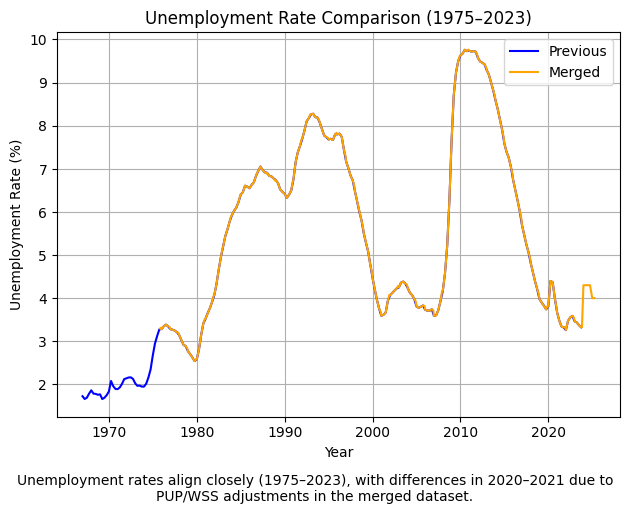

In [ ]:
# Plot UnemploymentRate
plt.plot(df_prev.index, df_prev['UnemploymentRate'], label='Previous', color='blue')
plt.plot(df_curr.index, df_curr['UnemploymentRate'], label='Merged', color='orange')
plt.title('Unemployment Rate Comparison (1975–2023)')
plt.xlabel('Year')
plt.ylabel('Unemployment Rate (%)')
plt.legend()
plt.grid(True)

# Remark
remark = "Unemployment rates align closely (1975–2023), with differences in 2020–2021 due to PUP/WSS adjustments in the merged dataset."
plt.figtext(0.5, -0.05, remark, wrap=True, ha='center', fontsize=10)
plt.tight_layout()

# Show plot
plt.show()